# TOPIC: RESILIENT MACHINE LEARNING-BASED FORECASTING OF ELECTRICITY DEMAND IN THE CONTEXT OF CLIMATE CHANGE. A CASE STUDY OF THE DYNAMIC WEATHER PATTERNS OF THE NORDIC COUNTRIES.

1. How does the performance of machine learning models compare with traditional econometric models in electricity demand forecasting?

2. What strategies can enhance the ability of these models to provide accurate demand forecasts?

3. What is the MOST resilient ML model?


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import ValueWarning
import statsmodels.stats.diagnostic as diagnostic
import statsmodels.tools.eval_measures as eval_measures
import statsmodels.tsa.vector_ar.var_model as var_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import warnings
from libtad import HolidaysService
from libtad.datatypes.holidays import HolidayType
from joblib import load
from joblib import dump
import os

In [2]:
df = pd.read_csv("nordext_df_climate.csv")

In [3]:
df

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,...,Climate_Change_Nor,Climate_Change_Swe,Climate_Change_Fin,Season,Climate Change - Norway,Climate Change - Sweden,Climate Change - Finland,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland
0,1/1/2010,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,...,0,0,0,Winter,False,False,False,1,1,0
1,1/2/2010,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,...,0,0,0,Winter,False,False,False,0,0,0
2,1/3/2010,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,...,0,0,0,Winter,False,False,False,0,0,0
3,1/4/2010,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,...,0,0,0,Winter,False,False,False,0,0,1
4,1/5/2010,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,...,0,0,0,Winter,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,12/27/2023,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,...,0,0,0,Winter,False,False,False,1,0,1
5109,12/28/2023,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,...,0,0,1,Winter,False,False,False,1,1,1
5110,12/29/2023,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,...,0,1,1,Winter,False,False,False,1,1,1
5111,12/30/2023,19033,17182,11327,-7.72,-1.63,-7.31,Saturday,12,2023,...,0,1,0,Winter,False,False,False,1,1,1


In [4]:
df.columns

Index(['Load Date', 'Total Load [MW] - Norway', 'Total Load [MW] - Sweden',
       'Total Load [MW] - Finland', 'Temp - Norway', 'Temp - Sweden',
       'Temp - Finland', 'Day of Week', 'Month', 'Year', 'Holiday_Norway',
       'Holiday_Sweden', 'Holiday_Finland', 'HDD_Norway', 'HDD_Sweden',
       'HDD_Finland', 'CDD_Norway', 'CDD_Sweden', 'CDD_Finland',
       'Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes',
       'Climate_Change_Nor', 'Climate_Change_Swe', 'Climate_Change_Fin',
       'Season', 'Climate Change - Norway', 'Climate Change - Sweden',
       'Climate Change - Finland', 'Climate_Change_Norway',
       'Climate_Change_Sweden', 'Climate_Change_Finland'],
      dtype='object')

In [5]:
df.Sweden_Temp_Extremes

0       1
1       1
2       1
3       1
4       1
       ..
5108    1
5109    0
5110    0
5111    0
5112    0
Name: Sweden_Temp_Extremes, Length: 5113, dtype: int64

In [6]:
df['Norway_Temp_Extremes'].unique()

array([1, 0, 2], dtype=int64)

In [7]:
# Specifying the path to my folder
my_plots = 'E:\ACADEMICS\THESIS\Thesis_all_plots\clim_swed'

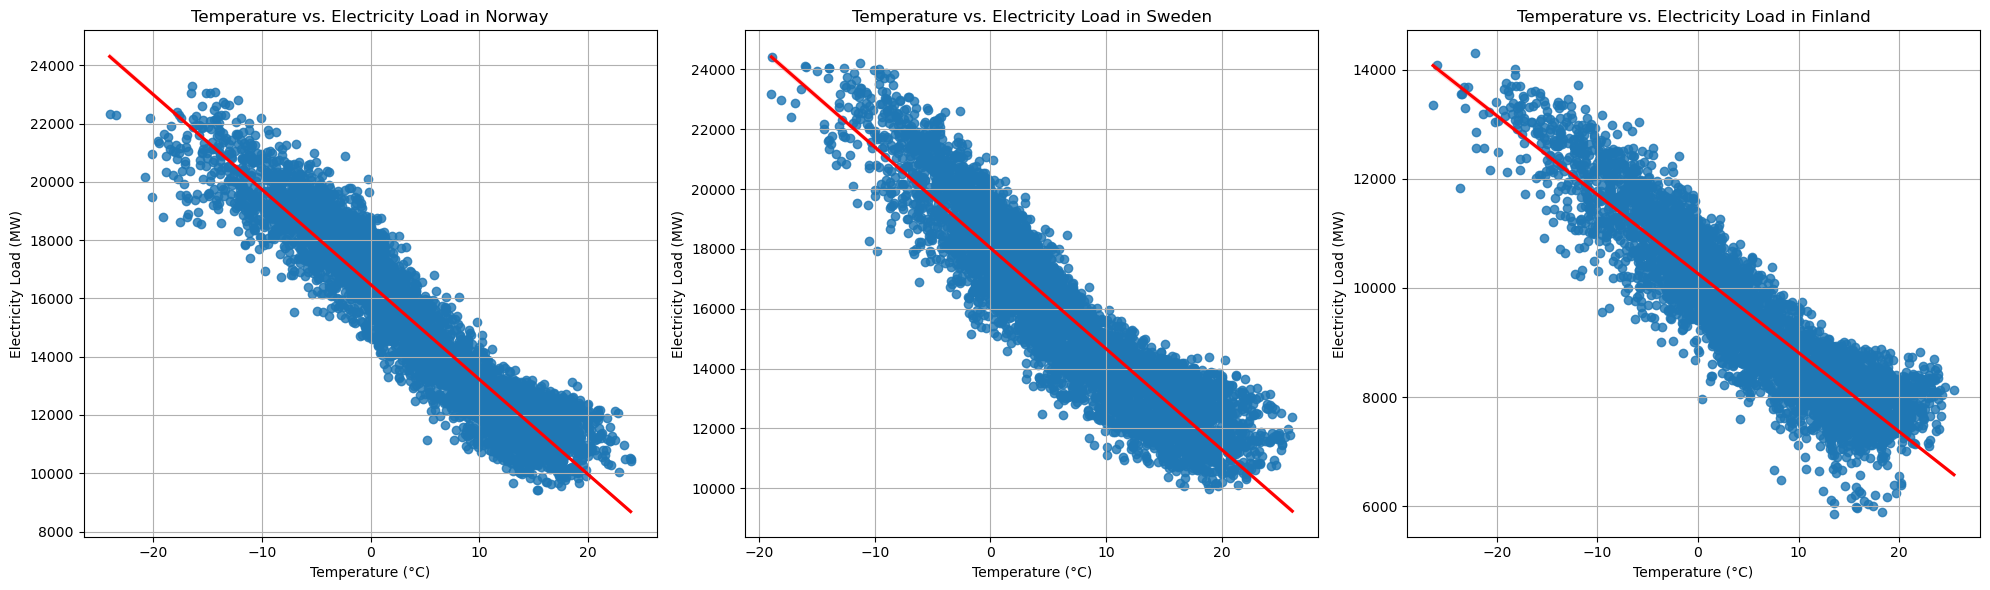

In [8]:
plt.figure(figsize=[20, 6])

# Temperature vs Electricity Load in Norway
plt.subplot(1, 3, 1)
sns.regplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Norway')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.grid(True)

# Temperature vs Electricity Load in Sweden
plt.subplot(1, 3, 2)
sns.regplot(x='Temp - Sweden', y='Total Load [MW] - Sweden', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Sweden')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.grid(True)

# Temperature vs Electricity Load in Finland
plt.subplot(1, 3, 3)
sns.regplot(x='Temp - Finland', y='Total Load [MW] - Finland', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Finland')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.tight_layout()
plt.grid(True)
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot1.png'), dpi = 600)  # Save as PNG format

plt.show()

In [9]:
# List of countries
countries = ['Norway', 'Sweden', 'Finland']

# Applying logarithmic transformation to the load and temperature for each country
for country in countries:
    # Adding a constant to ensure all temperatures are positive before taking log
    df[f'Log Total Load - {country}'] = np.log(df[f'Total Load [MW] - {country}'])
    df[f'Log Temp - {country}'] = np.log(df[f'Temp - {country}'] + 30)  # Adding 30 to ensure all temperatures are positive

# Displaying the first few rows to verify the new columns
for country in countries:
    print(df[[f'Log Total Load - {country}', f'Log Temp - {country}']].head())

   Log Total Load - Norway  Log Temp - Norway
0                 9.855714           2.928524
1                 9.881549           2.639771
2                 9.879758           2.718660
3                 9.924564           2.854169
4                 9.971240           2.341806
   Log Total Load - Sweden  Log Temp - Sweden
0                 9.888526           3.108168
1                 9.919164           3.044522
2                 9.944821           2.860485
3                 9.994835           2.844909
4                10.057795           2.613740
   Log Total Load - Finland  Log Temp - Finland
0                  9.343734            2.700690
1                  9.403355            2.395164
2                  9.386392            2.704042
3                  9.413281            3.121042
4                  9.451402            2.788708


In [10]:
df

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,...,Climate Change - Finland,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Log Total Load - Norway,Log Temp - Norway,Log Total Load - Sweden,Log Temp - Sweden,Log Total Load - Finland,Log Temp - Finland
0,1/1/2010,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,...,False,1,1,0,9.855714,2.928524,9.888526,3.108168,9.343734,2.700690
1,1/2/2010,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,...,False,0,0,0,9.881549,2.639771,9.919164,3.044522,9.403355,2.395164
2,1/3/2010,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,...,False,0,0,0,9.879758,2.718660,9.944821,2.860485,9.386392,2.704042
3,1/4/2010,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,...,False,0,0,1,9.924564,2.854169,9.994835,2.844909,9.413281,3.121042
4,1/5/2010,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,...,False,0,0,0,9.971240,2.341806,10.057795,2.613740,9.451402,2.788708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,12/27/2023,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,...,False,1,0,1,9.909718,3.087399,9.844958,3.064792,9.276877,3.126761
5109,12/28/2023,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,...,False,1,1,1,9.911009,3.061520,9.800568,3.265759,9.303466,3.248435
5110,12/29/2023,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,...,False,1,1,1,9.880782,3.088767,9.763536,3.394508,9.330698,3.298426
5111,12/30/2023,19033,17182,11327,-7.72,-1.63,-7.31,Saturday,12,2023,...,False,1,1,1,9.853930,3.103689,9.751618,3.345332,9.334945,3.121924


In [11]:
# Converting 'Load Date' into datetime format and setting it as the index
df['Load Date'] = pd.to_datetime(df['Load Date'])
df.set_index('Load Date', inplace=True)

# Splitting the data into training and testing sets
training_data = df.loc['2010-01-01':'2019-12-31'] #first twelve years
testing_data = df.loc['2020-01-01':'2023-12-31']  #Last two years

# Displaying the shapes of the training and testing sets as a quick verification
training_data.shape, testing_data.shape

((3652, 37), (1461, 37))

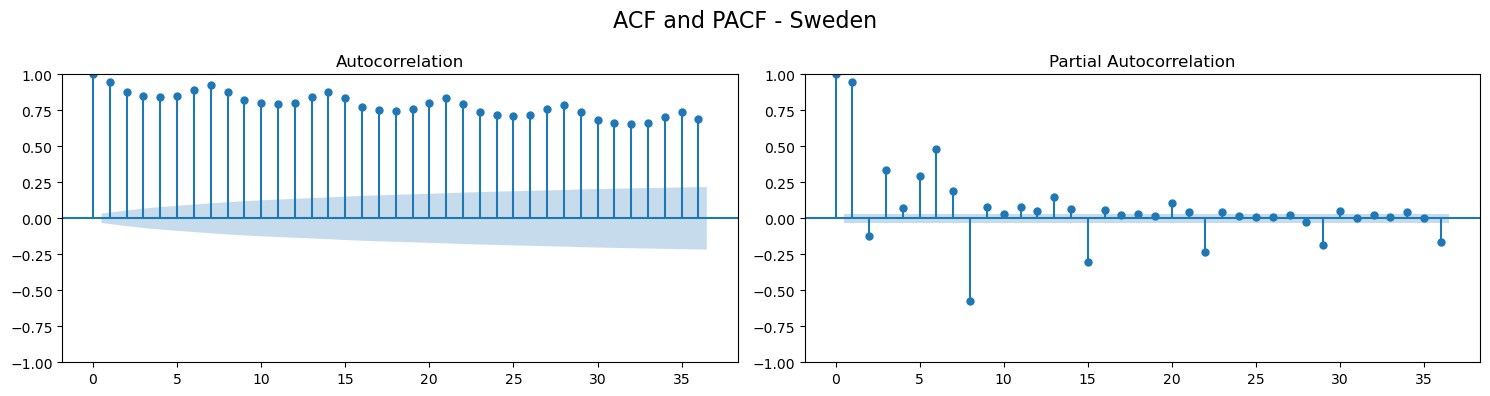

In [12]:
# Selecting SWEDENS's Total Load for demonstration
ts_sweden_load = training_data['Log Total Load - Sweden']

# Performing a stationarity test
adf_test_result = adfuller(ts_sweden_load)

# Preparing to plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle('ACF and PACF - Sweden', fontsize=16)  # Add heading
# Plotting Autocorrelation Function (ACF)
plot_acf(ts_sweden_load, ax=axes[0])

# Plotting Partial Autocorrelation Function (PACF)
plot_pacf(ts_sweden_load, ax=axes[1], method='ywm')

plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot2.png'), dpi = 600)  # Save as PNG format

plt.show()

# adf_test_result

In [13]:
# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop na to make sure the test works on non-NaN values
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'critical value ({key})'] = value
    print(out.to_string())  

# Testing for stationarity on the 'Total Load [MW] - Sweden' column
print("Total Load [MW] - Sweden:")
adf_test(df['Log Total Load - Sweden'], 'Log Total Load - Sweden')

# Testing for stationarity on the 'Temp - Sweden' column
print("\nTemp - Sweden:")
adf_test(df['Temp - Sweden'], 'Temp - Sweden')

Total Load [MW] - Sweden:
Augmented Dickey-Fuller Test: Log Total Load - Sweden
ADF test statistic        -4.594795
p-value                    0.000132
# lags used               33.000000
# observations          5079.000000
critical value (1%)       -3.431638
critical value (5%)       -2.862109
critical value (10%)      -2.567073

Temp - Sweden:
Augmented Dickey-Fuller Test: Temp - Sweden
ADF test statistic        -3.867677
p-value                    0.002286
# lags used               19.000000
# observations          5093.000000
critical value (1%)       -3.431635
critical value (5%)       -2.862108
critical value (10%)      -2.567072


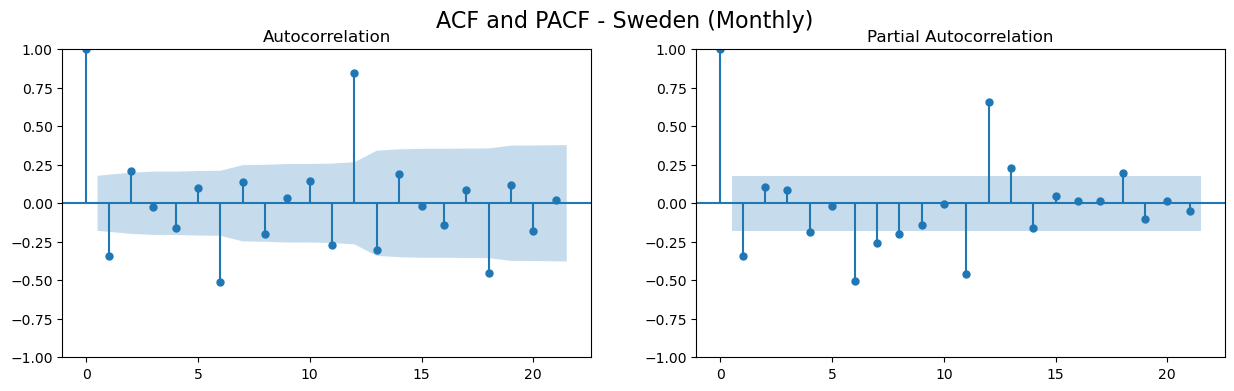

(None,
 (-2.1780465918237004,
  0.21430953198468128,
  11,
  108,
  {'1%': -3.4924012594942333,
   '5%': -2.8886968193364835,
   '10%': -2.5812552709190673},
  513.2497547799951))

In [14]:
# Resampling the data to monthly totals
monthly_df = df.resample('ME').sum()

# Splitting the monthly data into training and testing sets
monthly_training_data = monthly_df.loc['2010-01-01':'2019-12-31']  # First eleven years
monthly_testing_data = monthly_df.loc['2020-01-01':'2023-12-31']  # Last three years

# Selecting Sweden's Total Load for monthly data
monthly_ts_sweden_load = monthly_training_data['Log Total Load - Sweden']

# Performing a stationarity test on the monthly data
monthly_adf_test_result = adfuller(monthly_ts_sweden_load)

# Preparing to plot ACF and PACF for monthly data
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle('ACF and PACF - Sweden (Monthly)', fontsize=16)
plot_acf(monthly_ts_sweden_load, ax=axes[0])  # Plotting Autocorrelation Function (ACF)
plot_pacf(monthly_ts_sweden_load, ax=axes[1], method='ywm')  # Plotting Partial Autocorrelation Function (PACF)

plt.show(), monthly_adf_test_result

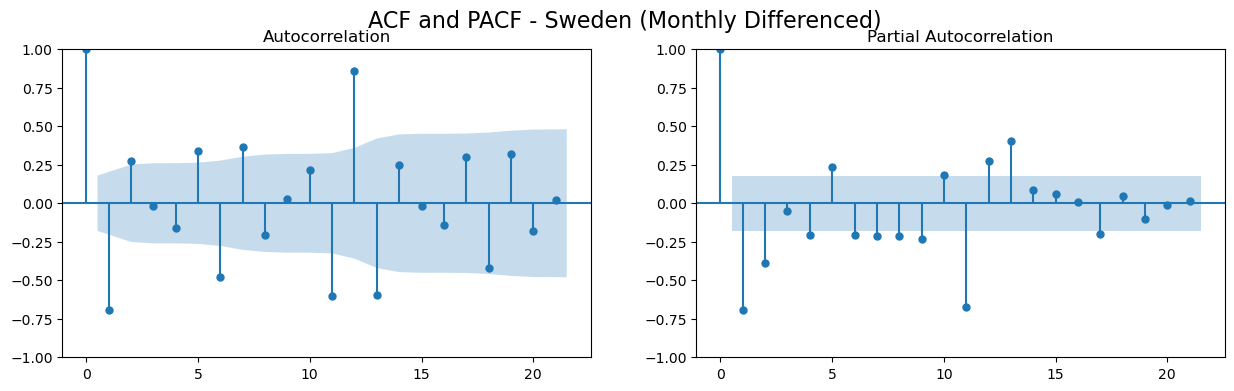

(None,
 (-27.231220452642322,
  0.0,
  10,
  108,
  {'1%': -3.4924012594942333,
   '5%': -2.8886968193364835,
   '10%': -2.5812552709190673},
  512.0311503451343))

In [15]:
# Differencing the monthly data
monthly_ts_sweden_load_diff = monthly_ts_sweden_load.diff().dropna()  # Removing NA values generated by differencing

# Performing a stationarity test on the differenced data
diff_adf_test_result = adfuller(monthly_ts_sweden_load_diff)

# Preparing to plot ACF and PACF for differenced data
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle('ACF and PACF - Sweden (Monthly Differenced)', fontsize=16)
plot_acf(monthly_ts_sweden_load_diff, ax=axes[0])  # Plotting Autocorrelation Function (ACF)
plot_pacf(monthly_ts_sweden_load_diff, ax=axes[1], method='ywm')  # Plotting Partial Autocorrelation Function (PACF)

plt.show(), diff_adf_test_result

C:\Users\sammy\AppData\Local\Temp\ipykernel_26272\2921271765.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_all = df.resample('M').sum()


ADF Test Result for Norway:
ADF Statistic: -1.095740
p-value: 0.716768
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Failed to Reject Ho - Norway Time Series is Non-Stationary
ADF Test Result for Sweden:
ADF Statistic: -2.972963
p-value: 0.037498
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Sweden Time Series is Stationary
ADF Test Result for Finland:
ADF Statistic: -2.354443
p-value: 0.155009
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Failed to Reject Ho - Finland Time Series is Non-Stationary


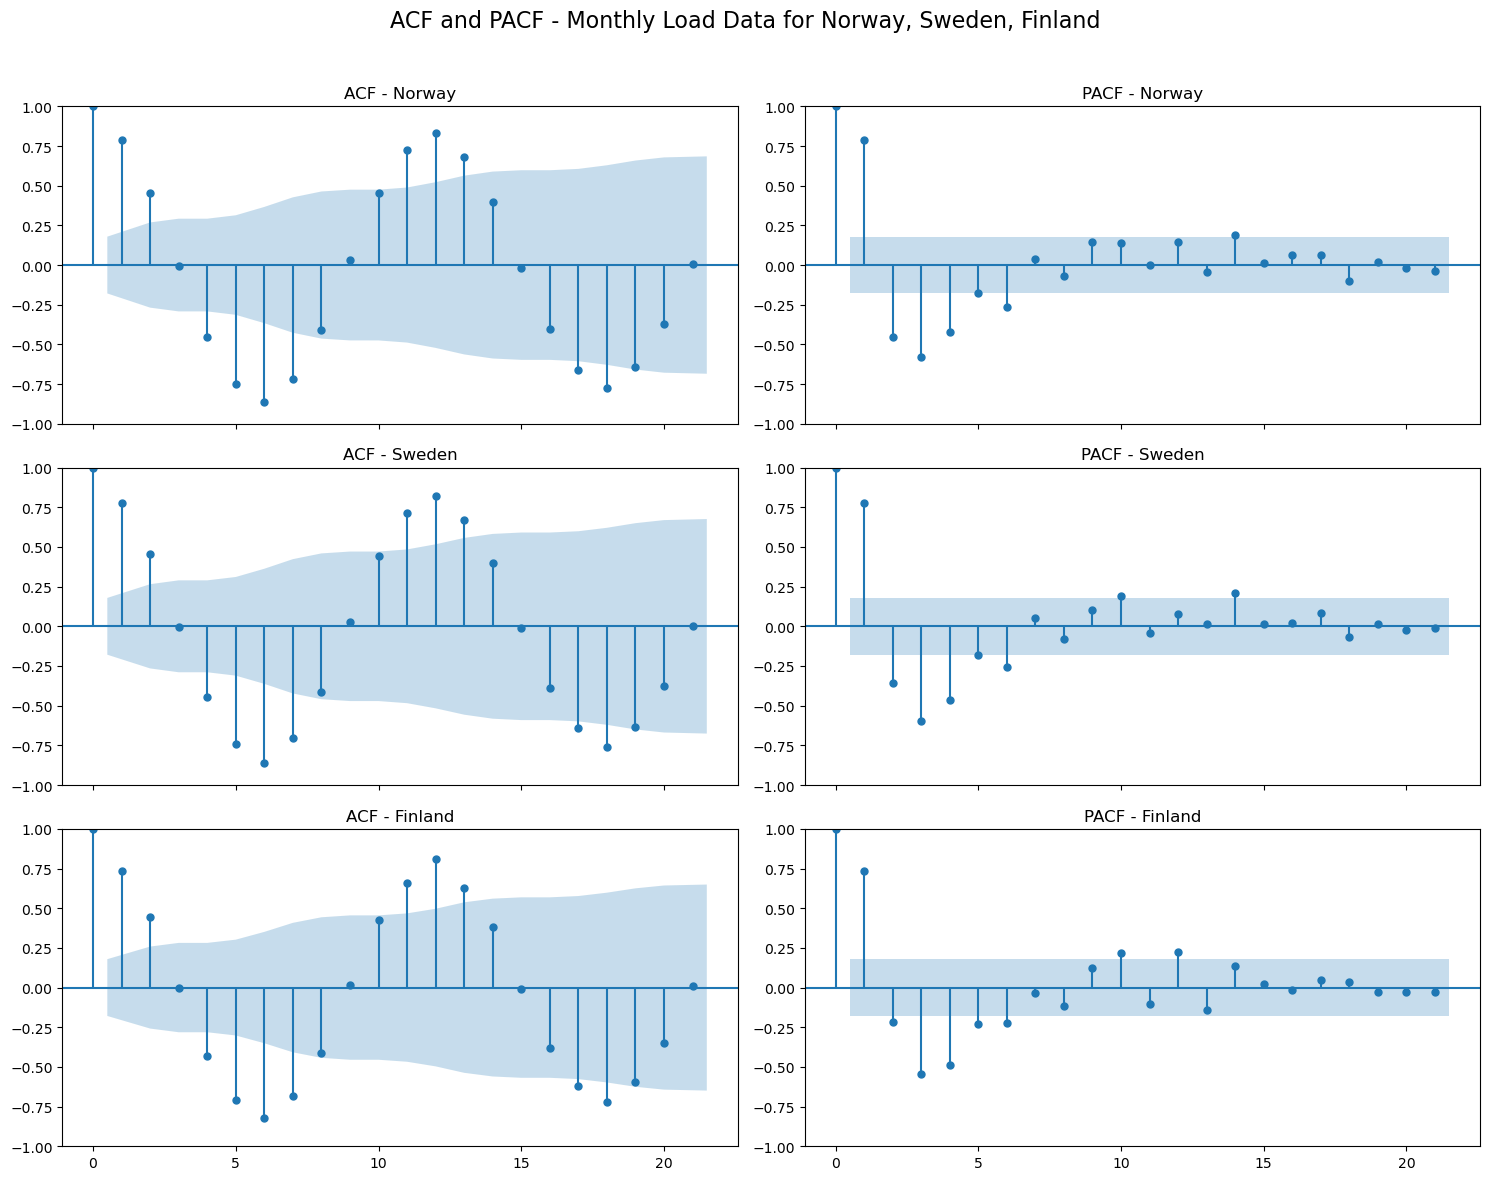

In [16]:
# Resampling the data to monthly totals for all countries
monthly_data_all = df.resample('M').sum()

# Splitting the monthly data into training and testing sets for all countries
monthly_training_data_all = monthly_data_all.loc['2010-01-01':'2019-12-31']  # First eleven years
monthly_testing_data_all = monthly_data_all.loc['2020-01-01':'2023-12-31']  # Last three years

# Initializing plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
plt.suptitle('ACF and PACF - Monthly Load Data for Norway, Sweden, Finland', fontsize=16)

# Lists of countries for looping
countries = ['Norway', 'Sweden', 'Finland']

# Analyzing each country's data
adf_results = {}
for i, country in enumerate(countries):
    # Selecting data for each country
    load_column = f'Total Load [MW] - {country}'
    monthly_load = monthly_training_data_all[load_column]
    
    # Performing a stationarity test on the monthly data
    adf_test_result = adfuller(monthly_load)
    adf_results[country] = adf_test_result
    
    # Print ADF test results
    print(f'ADF Test Result for {country}:')
    print('ADF Statistic: %f' % adf_test_result[0])
    print('p-value: %f' % adf_test_result[1])
    print('Critical Values:')
    for key, value in adf_test_result[4].items():
        print(f'\t{key}: {value:.3f}')
    if adf_test_result[0] < adf_test_result[4]['5%']:
        print(f"Reject Ho - {country} Time Series is Stationary")
    else:
        print(f"Failed to Reject Ho - {country} Time Series is Non-Stationary")
    
    # Plotting Autocorrelation Function (ACF)
    plot_acf(monthly_load, ax=axes[i, 0], title=f'ACF - {country}')
    axes[i, 0].set_title(f'ACF - {country}')
    
    # Plotting Partial Autocorrelation Function (PACF)
    plot_pacf(monthly_load, ax=axes[i, 1], method='ywm', title=f'PACF - {country}')
    axes[i, 1].set_title(f'PACF - {country}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('acf_pacf.png', dpi=600)  # Saving as PNG format at high resolution
#plt.show()


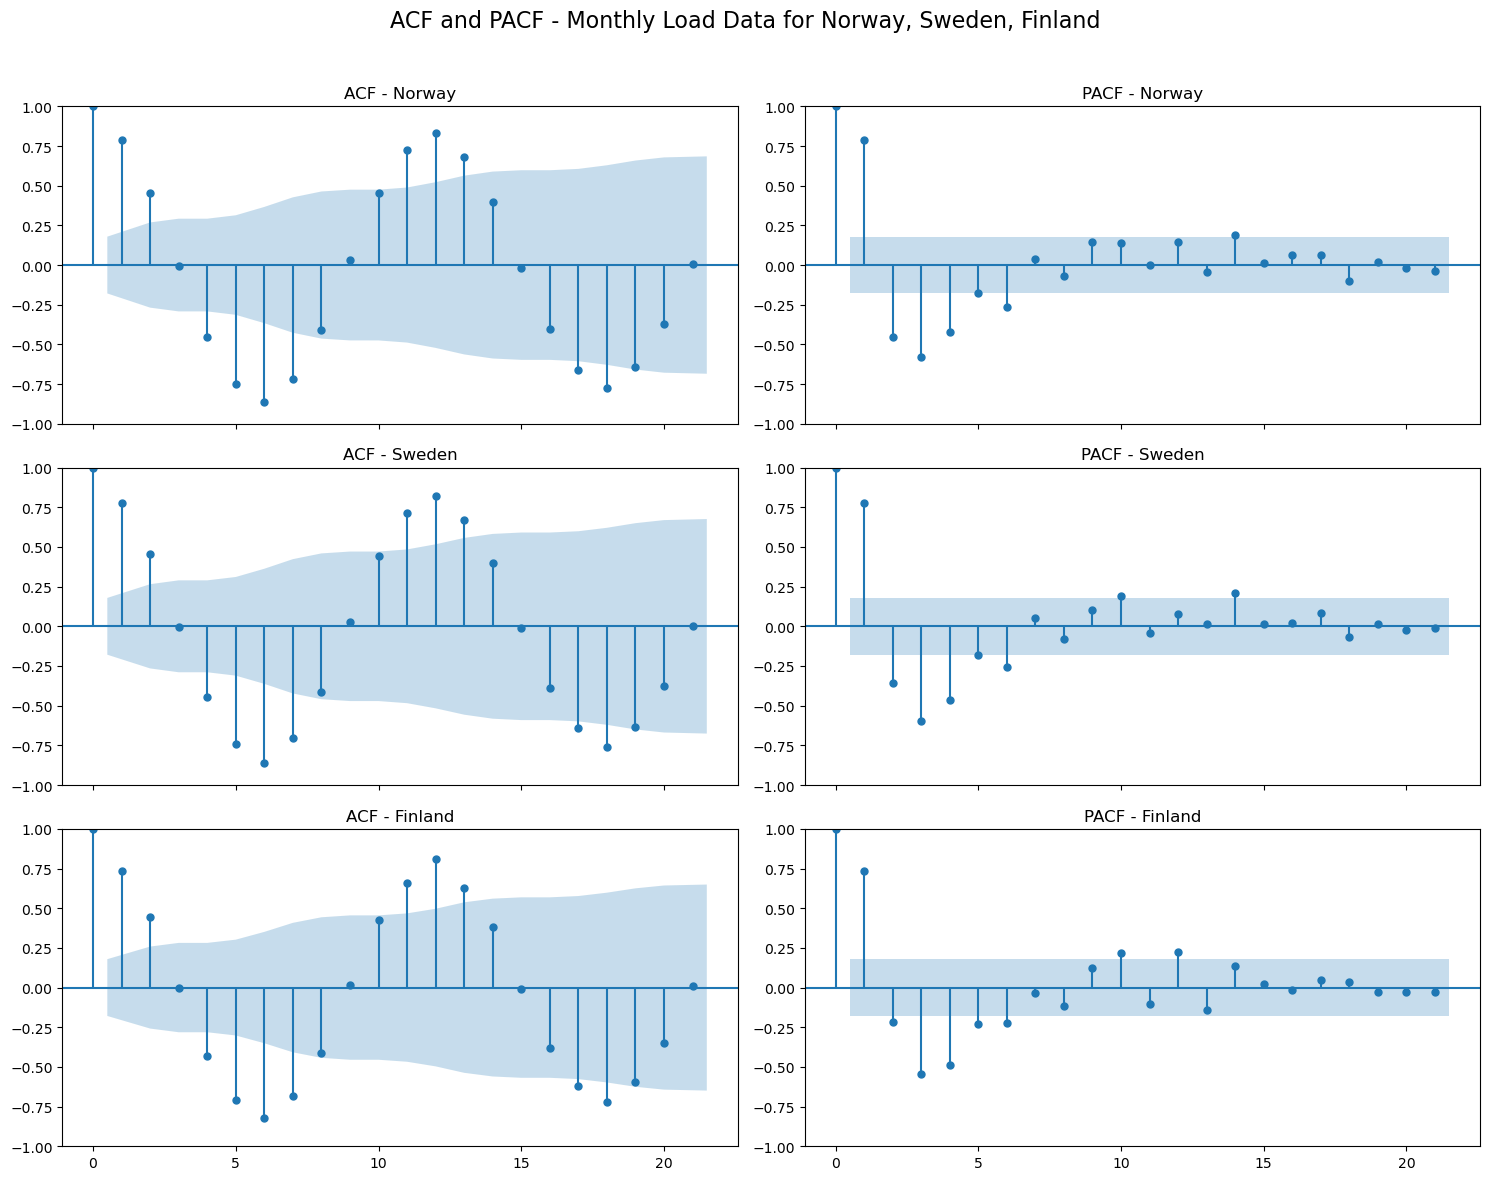

(None,
 {'Norway': (-1.0957402491710702,
   0.7167676515001011,
   11,
   108,
   {'1%': -3.4924012594942333,
    '5%': -2.8886968193364835,
    '10%': -2.5812552709190673},
   2436.4148496433013),
  'Sweden': (-2.9729626186783995,
   0.03749766415374532,
   11,
   108,
   {'1%': -3.4924012594942333,
    '5%': -2.8886968193364835,
    '10%': -2.5812552709190673},
   2439.810919729007),
  'Finland': (-2.354443438067748,
   0.1550092157774472,
   13,
   106,
   {'1%': -3.4936021509366793,
    '5%': -2.8892174239808703,
    '10%': -2.58153320754717},
   2328.2130113282897)})

In [17]:
# Resampling the data to monthly totals for all countries
monthly_data_all = df.resample('ME').sum()

# Splitting the monthly data into training and testing sets for all countries
monthly_training_data_all = monthly_data_all.loc['2010-01-01':'2019-12-31']  
monthly_testing_data_all = monthly_data_all.loc['2020-01-01':'2023-12-31']  
# Initializing plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
plt.suptitle('ACF and PACF - Monthly Load Data for Norway, Sweden, Finland', fontsize=16)

# NORDISC
countries = ['Norway', 'Sweden', 'Finland']

# Analyzing each country's data
adf_results = {}
for i, country in enumerate(countries):
    # Selecting data for each country
    load_column = f'Total Load [MW] - {country}'
    monthly_load = monthly_training_data_all[load_column]
    
    # Performing a stationarity test on the monthly data
    adf_test_result = adfuller(monthly_load)
    adf_results[country] = adf_test_result
    
    # Plotting Autocorrelation Function (ACF)
    plot_acf(monthly_load, ax=axes[i, 0], title=f'ACF - {country}')
    axes[i, 0].set_title(f'ACF - {country}')
    
    # Plotting Partial Autocorrelation Function (PACF)
    plot_pacf(monthly_load, ax=axes[i, 1], method='ywm', title=f'PACF - {country}')
    axes[i, 1].set_title(f'PACF - {country}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(my_plots, 'acf_pacf.png'), dpi=600)  # Saving as PNG format at high resolution
plt.show(), adf_results

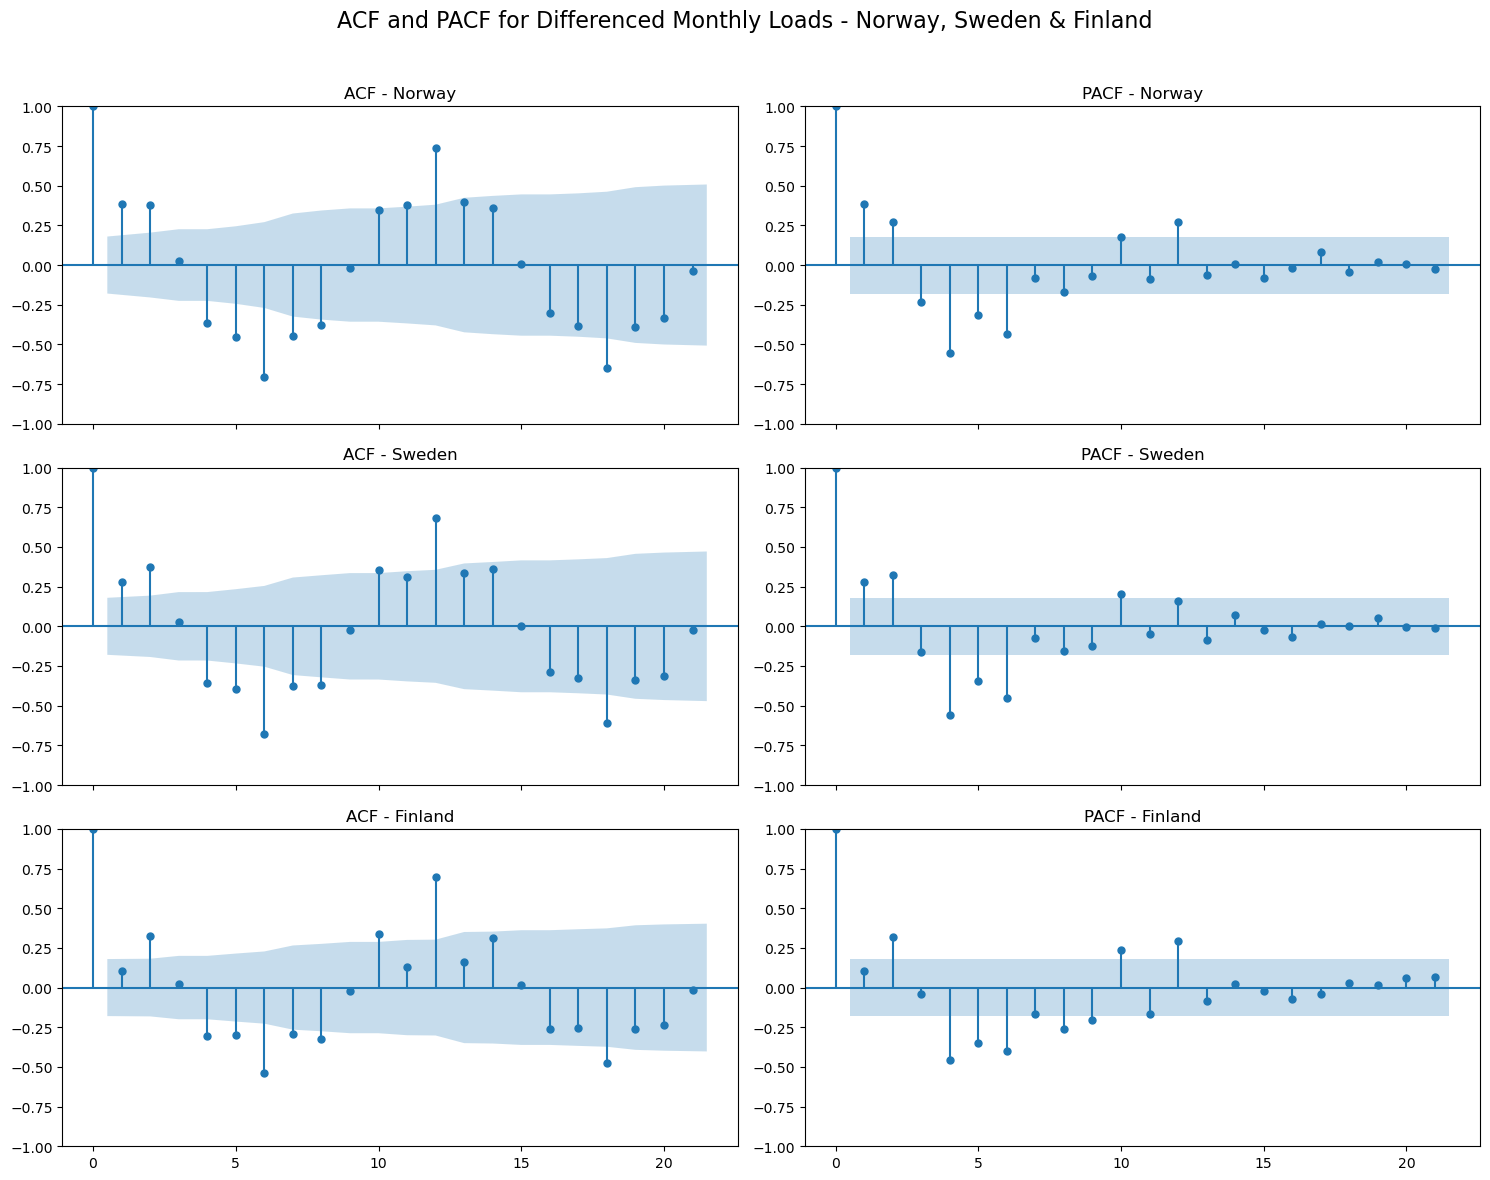

(None,
 {'Norway': (-9.957351322890874,
   2.4243599810232474e-17,
   10,
   108,
   {'1%': -3.4924012594942333,
    '5%': -2.8886968193364835,
    '10%': -2.5812552709190673},
   2413.6128758174987),
  'Sweden': (-4.542309256138687,
   0.0001647765248363878,
   13,
   105,
   {'1%': -3.4942202045135513,
    '5%': -2.889485291005291,
    '10%': -2.5816762131519275},
   2420.438948632334),
  'Finland': (-4.307299631906974,
   0.00043145915870213697,
   13,
   105,
   {'1%': -3.4942202045135513,
    '5%': -2.889485291005291,
    '10%': -2.5816762131519275},
   2311.0429788268093)})

In [18]:
# Differencing the monthly data for all countries and performing ADF tests
diff_adf_results = {}
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
plt.suptitle('ACF and PACF for Differenced Monthly Loads - Norway, Sweden & Finland', fontsize=16)

for i, country in enumerate(countries):
    # Differencing the data
    load_column = f'Total Load [MW] - {country}'
    monthly_load_diff = monthly_training_data_all[load_column].diff().dropna()

    # ADF test on the differenced data
    adf_result = adfuller(monthly_load_diff)
    diff_adf_results[country] = adf_result

    # Plotting ACF
    plot_acf(monthly_load_diff, ax=axes[i, 0], title=f'ACF - {country}')
    
    # Plotting PACF
    plot_pacf(monthly_load_diff, ax=axes[i, 1], method='ywm', title=f'PACF - {country}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(my_plots, 'diff_acf_pacf.png'), dpi=600)  # Saving as PNG format at high resolution

plt.show(), diff_adf_results

In [19]:
# Resampling the temperature data to monthly averages for all countries
monthly_temp_data = {
    "Norway": df['Temp - Norway'].resample('ME').mean(),
    "Sweden": df['Temp - Sweden'].resample('ME').mean(),
    "Finland": df['Temp - Finland'].resample('ME').mean()
}

# Performing ADF tests on the resampled monthly average temperature data
temp_adf_results = {}
for country, temp_series in monthly_temp_data.items():
    adf_result_temp = adfuller(temp_series.dropna())  # Ensuring no NA values
    temp_adf_results[country] = adf_result_temp

# Displaying the ADF results for each country's temperature data
temp_adf_results

{'Norway': (-10.94914004688496,
  8.88905612086436e-20,
  5,
  162,
  {'1%': -3.471374345647024,
   '5%': -2.8795521079291966,
   '10%': -2.5763733302850174},
  687.4218563140186),
 'Sweden': (-3.582185002818653,
  0.006110889396302457,
  11,
  156,
  {'1%': -3.4729792729247793,
   '5%': -2.8802520918255534,
   '10%': -2.5767469641683105},
  645.0091536865256),
 'Finland': (-3.813434715911994,
  0.002772812758732717,
  11,
  156,
  {'1%': -3.4729792729247793,
   '5%': -2.8802520918255534,
   '10%': -2.5767469641683105},
  712.7570053856763)}

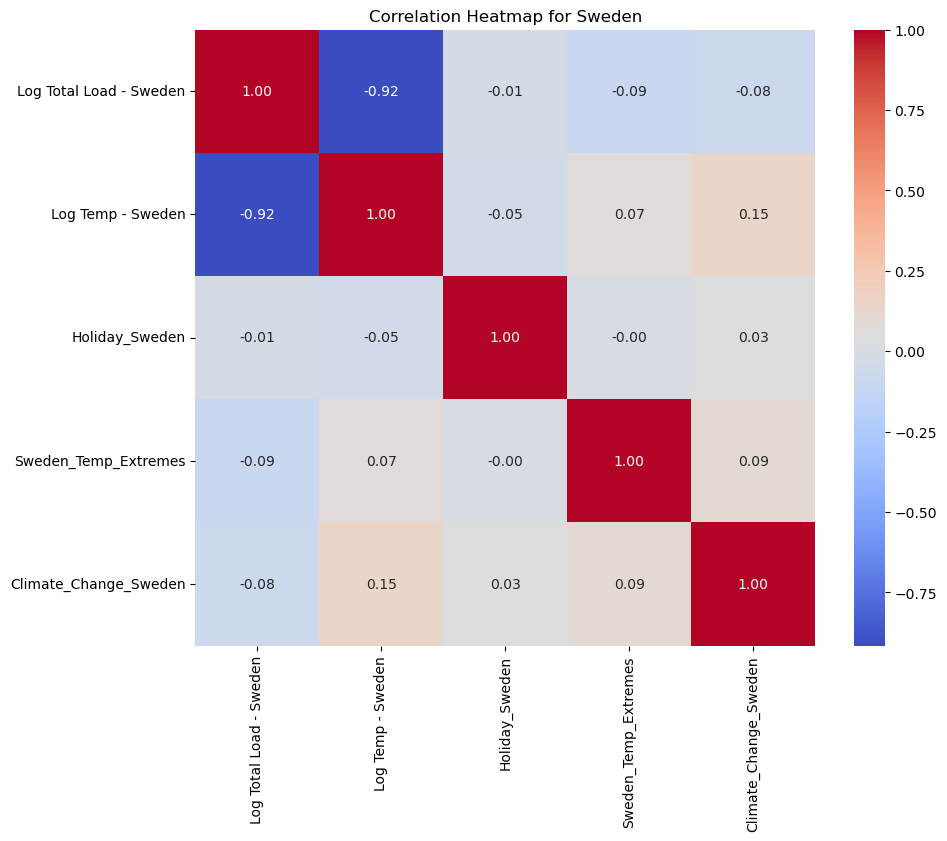

In [20]:

sweden_columns = ['Log Total Load - Sweden', 'Log Temp - Sweden','Holiday_Sweden','Sweden_Temp_Extremes', 'Climate_Change_Sweden']
sweden_df = df[sweden_columns]

# Calculating correlation matrix
correlation_matrix = sweden_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Sweden')
plt.savefig(os.path.join(my_plots, 'corr.png'), dpi=600)  # Saving as PNG format at high resolution

plt.show()


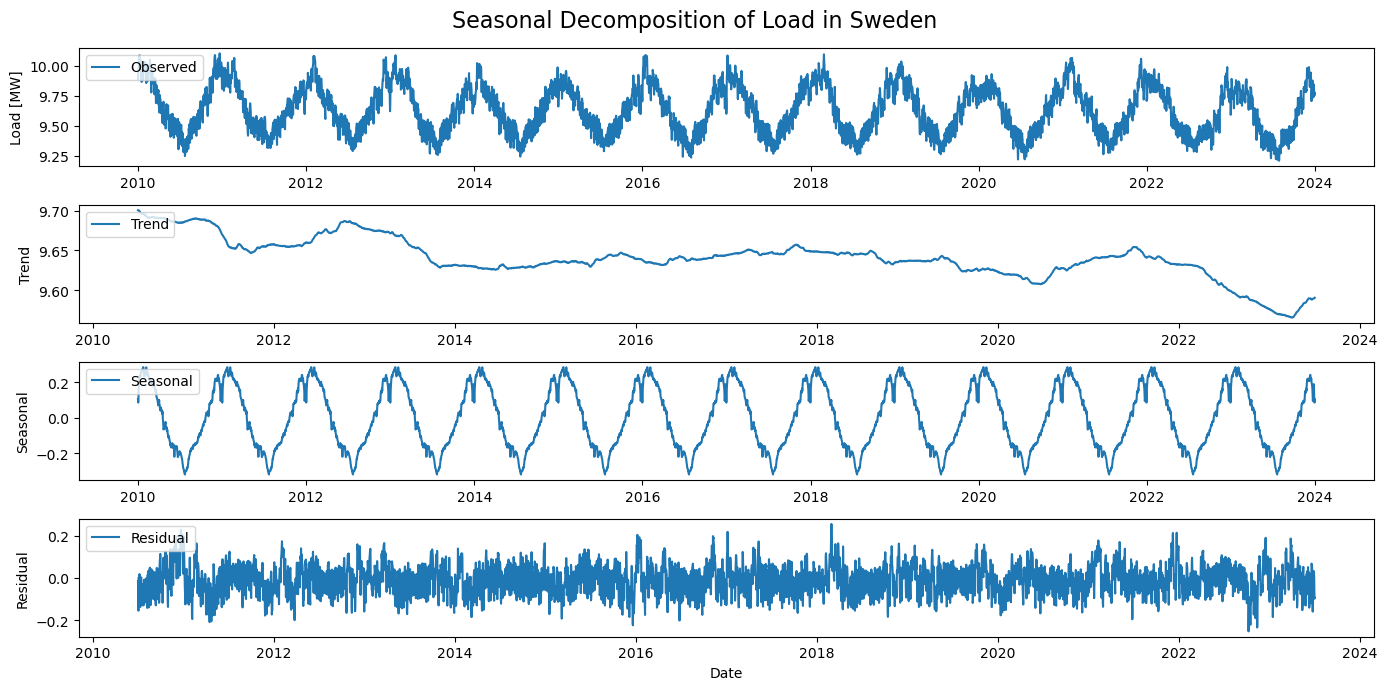

In [21]:
# Seasonal decomposition for Sweden load data
decomposed_sweden = seasonal_decompose(df['Log Total Load - Sweden'], model='additive', period=365)

# Plotting the decomposed components for Sweden load data
plt.figure(figsize=(14, 7))
plt.suptitle('Seasonal Decomposition of Load in Sweden', fontsize=16)  # Add heading
plt.subplot(411)
plt.plot(decomposed_sweden.observed, label='Observed')
plt.legend(loc='upper left')
plt.ylabel('Load [MW]')  # Add y-axis label
plt.subplot(412)
plt.plot(decomposed_sweden.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')  # Add y-axis label
plt.subplot(413)
plt.plot(decomposed_sweden.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')  # Add y-axis label
plt.subplot(414)
plt.plot(decomposed_sweden.resid, label='Residual')
plt.legend(loc='upper left')
plt.ylabel('Residual')  # Add y-axis label
plt.xlabel('Date')  # Add x-axis label
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'decompose.png'), dpi=600)  # Save as PNG format
plt.show()

In [22]:
warnings.simplefilter('ignore', ValueWarning)

In [23]:
# Resample to monthly data and aggregate appropriately
monthly_data = df.resample('ME').agg({
    'Log Total Load - Sweden': 'sum',  # Sum of load for the month
    'Temp - Sweden': 'mean',            # Average temperature for the month
    'Holiday_Sweden': 'sum',            # Total count of holiday days in the month
    'Sweden_Temp_Extremes': 'sum',      # Total count of days with climate variability
    'Climate_Change_Sweden': 'sum'      # Total count of days with temperatures above the mean 
})

# Split into training and testing sets
y_train = monthly_data.loc['2010-01-01':'2019-12-31', 'Log Total Load - Sweden']
X_train = monthly_data.loc['2010-01-01':'2019-12-31', ['Temp - Sweden','Holiday_Sweden']]
y_test = monthly_data.loc['2020-01-01':'2023-12-31', 'Log Total Load - Sweden']
X_test = monthly_data.loc['2020-01-01':'2023-12-31', ['Temp - Sweden','Holiday_Sweden']]

In [24]:
#y_train = training_data['Total Load [MW] - Sweden']
#X_train = training_data[['Temp - Sweden']]
#y_test = testing_data['Total Load [MW] - Sweden']
#X_test = testing_data[['Temp - Sweden']]

C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


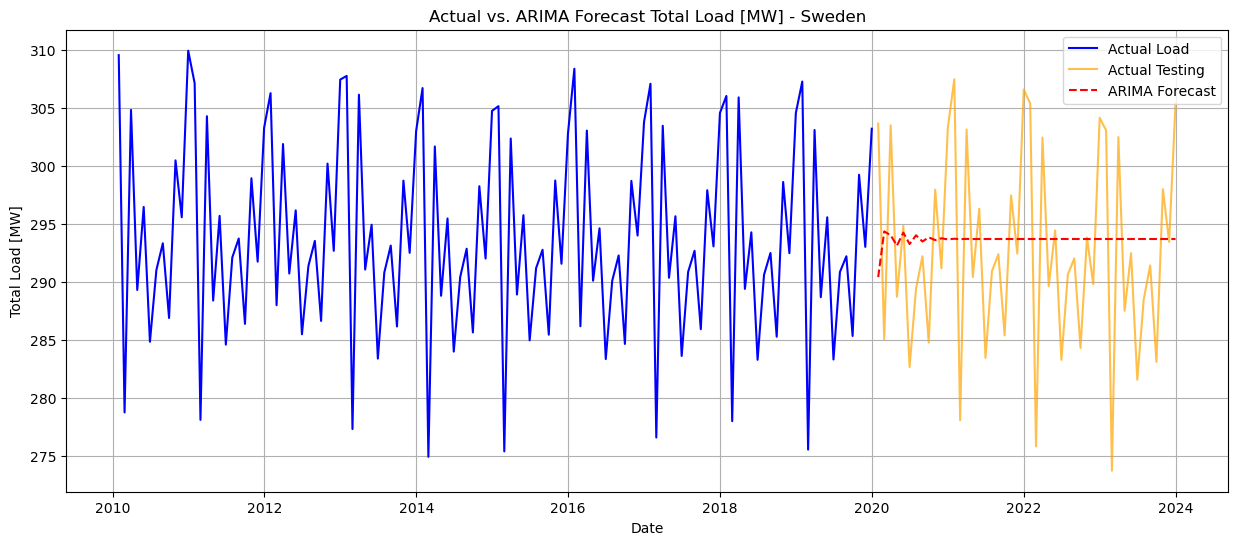

(8.88262878000575, 29.468956698824286)

In [25]:
# Fitting an ARIMA(1,0,1) model to Norway's total load data, without using exogenous variables in this part
model_arima_sweden = SARIMAX(y_train, order=(2,1,2), seasonal_order=(0,0,0,0))
model_arima_fit_sweden = model_arima_sweden.fit()

# Making predictions on the training data for comparison
train_pred_sweden = model_arima_fit_sweden.predict(start=y_train.index[0], end=y_train.index[-1])

# Making forecasts on the test data
test_forecast_sweden = model_arima_fit_sweden.predict(start=y_test.index[0], end=y_test.index[-1])

# Plotting without training predictions for a clearer view of actual vs. forecasted in the test period
plt.figure(figsize=(15, 6))

# Plotting training data (actual)
plt.plot(y_train.index, y_train, label='Actual Load', color='blue')

# Plotting testing data (actual)
plt.plot(y_test.index, y_test, label='Actual Testing', color='orange', alpha=0.7)

# Plotting testing forecasts
plt.plot(test_forecast_sweden.index, test_forecast_sweden, label='ARIMA Forecast', color='red', linestyle='--')

plt.title('Actual vs. ARIMA Forecast Total Load [MW] - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [MW]')
plt.legend()
plt.grid(True)
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot4.png'), dpi = 600)  # Save as PNG format

plt.show()

# Evaluating model performance on the training set
mae_sweden = mean_absolute_error(y_train, train_pred_sweden)
rmse_sweden = np.sqrt(mean_squared_error(y_train, train_pred_sweden))

mae_sweden, rmse_sweden

In [26]:
df.columns

Index(['Total Load [MW] - Norway', 'Total Load [MW] - Sweden',
       'Total Load [MW] - Finland', 'Temp - Norway', 'Temp - Sweden',
       'Temp - Finland', 'Day of Week', 'Month', 'Year', 'Holiday_Norway',
       'Holiday_Sweden', 'Holiday_Finland', 'HDD_Norway', 'HDD_Sweden',
       'HDD_Finland', 'CDD_Norway', 'CDD_Sweden', 'CDD_Finland',
       'Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes',
       'Climate_Change_Nor', 'Climate_Change_Swe', 'Climate_Change_Fin',
       'Season', 'Climate Change - Norway', 'Climate Change - Sweden',
       'Climate Change - Finland', 'Climate_Change_Norway',
       'Climate_Change_Sweden', 'Climate_Change_Finland',
       'Log Total Load - Norway', 'Log Temp - Norway',
       'Log Total Load - Sweden', 'Log Temp - Sweden',
       'Log Total Load - Finland', 'Log Temp - Finland'],
      dtype='object')

#### LETS BUILD SARIMAX

In [27]:
# Defining the target and exogenous variables for the SARIMAX model
# Building and fitting the SARIMAX model
sarimax_model = SARIMAX(y_train, exog=X_train, order=(2, 0, 1), seasonal_order=(2, 1, 1,12))
sarimax_result = sarimax_model.fit()

# Making predictions on the training data for comparison
# For in-sample predictions, include the exogenous variables for the corresponding period
train_pred_sarimax_sweden = sarimax_result.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train)

# Making predictions on the test set
predictions = sarimax_result.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

sarimax_result.summary()

C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Log Total Load - Sweden   No. Observations:                  120
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -217.858
Date:                            Mon, 17 Jun 2024   AIC                            453.715
Time:                                    11:20:59   BIC                            477.854
Sample:                                01-31-2010   HQIC                           463.503
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Temp - Sweden     -0.5612      0.150     -3.743      0.000      -0.855      -0.267
Holiday_Sweden  7.365e-06    690.364   1.07e-08      1.000   -1353.088    1353.088
ar.L1             -0.6777      2.809     -0.241      0.809      -6.183       4.828
ar.L2              0.0498      0.381      0.131      0.896      -0.697       0.797
ma.L1              0.6882      2.803      0.246      0.806      -4.806       6.182
ar.S.L12           0.5416   1604.389      0.000      1.000   -3144.002    3145.086
ar.S.L24           0.4583    735.360      0.001      1.000   -1440.821    1441.738
ma.S.L12          -1.0000   2179.525     -0.000      1.000   -4272.790    4270.790
sigma2             3.2230   1853.680      0.002      0.999   -3629.924    3636.370
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2060.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             2.99
Prob(H) (two-sided):                  0.01   Kurtosis:                        23.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

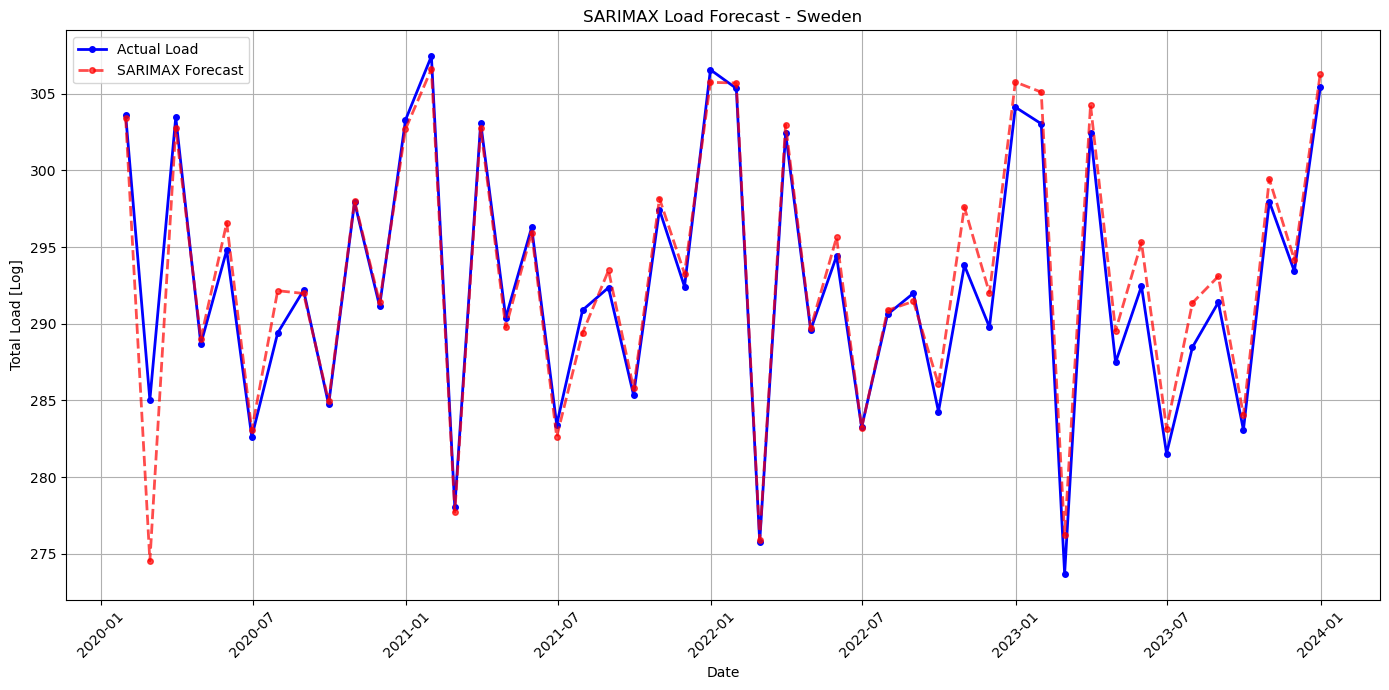

In [28]:
# Plotting the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(predictions.index, predictions, label='SARIMAX Forecast', color='red', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('SARIMAX Load Forecast - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to the winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot5.png'), dpi = 600)  # Save as PNG format

plt.show()

In [29]:
#mae, mape, mse
# Calculating MSE
mse_sarimax = mean_squared_error(y_test, predictions)

# Calculating MAE
mae_sarimax = mean_absolute_error(y_test, predictions)

# Calculating RMSE
rmse_sarimax = np.sqrt(mse_sarimax)

# Calculating MAPE
mape_sarimax = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"MSE (SARIMAX): {mse_sarimax}")
print(f"MAE (SARIMAX): {mae_sarimax}")
print(f"RMSE (SARIMAX): {rmse_sarimax}")
print(f"MAPE (SARIMAX): {mape_sarimax}%")

MSE (SARIMAX): 4.215981749964091
MAE (SARIMAX): 1.2723200647314126
RMSE (SARIMAX): 2.053285598732941
MAPE (SARIMAX): 0.4373949534431526%


In [30]:
# Calculate in-sample predictions
train_predictions = sarimax_result.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train)

# Calculate in-sample error metrics
mse_in_sample = mean_squared_error(y_train, train_predictions)
mae_in_sample = mean_absolute_error(y_train, train_predictions)
rmse_in_sample = np.sqrt(mse_in_sample)
mape_in_sample = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100

# Print in-sample error metrics
print("In-sample error metrics:")
print(f"MSE (SARIMAX): {mse_in_sample}")
print(f"MAE (SARIMAX): {mae_in_sample}")
print(f"RMSE (SARIMAX): {rmse_in_sample}")
print(f"MAPE (SARIMAX): {mape_in_sample}%")

In-sample error metrics:
MSE (SARIMAX): 8867.97420821103
MAE (SARIMAX): 30.49903887153142
RMSE (SARIMAX): 94.16992199323003
MAPE (SARIMAX): 10.345481679282278%


In [31]:
df.columns

Index(['Total Load [MW] - Norway', 'Total Load [MW] - Sweden',
       'Total Load [MW] - Finland', 'Temp - Norway', 'Temp - Sweden',
       'Temp - Finland', 'Day of Week', 'Month', 'Year', 'Holiday_Norway',
       'Holiday_Sweden', 'Holiday_Finland', 'HDD_Norway', 'HDD_Sweden',
       'HDD_Finland', 'CDD_Norway', 'CDD_Sweden', 'CDD_Finland',
       'Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes',
       'Climate_Change_Nor', 'Climate_Change_Swe', 'Climate_Change_Fin',
       'Season', 'Climate Change - Norway', 'Climate Change - Sweden',
       'Climate Change - Finland', 'Climate_Change_Norway',
       'Climate_Change_Sweden', 'Climate_Change_Finland',
       'Log Total Load - Norway', 'Log Temp - Norway',
       'Log Total Load - Sweden', 'Log Temp - Sweden',
       'Log Total Load - Finland', 'Log Temp - Finland'],
      dtype='object')

#### EXPANDING THE EXOGENOUS VARIABLES TO EXTREME WEATHER CONDITIONS

In [32]:
#Lets create an interaction term
monthly_data['Clim_ext'] = monthly_data['Sweden_Temp_Extremes'] * monthly_data['Climate_Change_Sweden']

In [33]:
# Adjusting the selection of exogenous variables for Sweden
X_train_exog = monthly_data.loc['2010-01-01':'2019-12-31', ['Temp - Sweden', 'Holiday_Sweden','Sweden_Temp_Extremes', 'Climate_Change_Sweden', 'Clim_ext']]
X_test_exog = monthly_data.loc['2020-01-01':'2023-12-31', ['Temp - Sweden', 'Holiday_Sweden', 'Sweden_Temp_Extremes', 'Climate_Change_Sweden', 'Clim_ext']]

#### SARIMAX WITH EXTREME TEMPERATURE

In [34]:
# Defining the target and exogenous variables for the SARIMAX model
# Building and fitting the SARIMAX model
sarimax_model2 = SARIMAX(y_train, exog=X_train_exog, order=(2, 0, 1), seasonal_order=(2, 1, 1, 12))
sarimax_result2 = sarimax_model2.fit()

# Making predictions on the training data for comparison
# For in-sample predictions, include the exogenous variables for the corresponding period
train_pred_sarimax2_sweden = sarimax_result2.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train_exog)


# Making predictions on the test set
predictions2 = sarimax_result2.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test_exog)

sarimax_result2.summary()

C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mo

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Log Total Load - Sweden   No. Observations:                  120
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -192.685
Date:                            Mon, 17 Jun 2024   AIC                            409.370
Time:                                    11:21:04   BIC                            441.555
Sample:                                01-31-2010   HQIC                           422.420
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Temp - Sweden            -0.6255      0.234     -2.675      0.007      -1.084      -0.167
Holiday_Sweden        -8.765e-08   5.51e-07     -0.159      0.874   -1.17e-06    9.93e-07
Sweden_Temp_Extremes     -0.0130      0.173     -0.075      0.940      -0.353       0.327
Climate_Change_Sweden     0.0301      0.103      0.293      0.769      -0.171       0.231
Clim_ext                  0.0022      0.008      0.283      0.777      -0.013       0.018
ar.L1                     0.0204      1.706      0.012      0.990      -3.323       3.364
ar.L2                     0.1058      0.242      0.436      0.662      -0.369       0.581
ma.L1                     0.0274      1.718      0.016      0.987      -3.340       3.395
ar.S.L12                 -0.3776      0.119     -3.173      0.002      -0.611      -0.144
ar.S.L24                 -0.3873      0.065     -5.971      0.000      -0.514      -0.260
ma.S.L12                 -0.7021      0.299     -2.350      0.019      -1.288      -0.117
sigma2                    1.5864      0.404      3.924      0.000       0.794       2.379
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2252.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             3.14
Prob(H) (two-sided):                  0.01   Kurtosis:                        24.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+17. Standard errors may be unstable.
"""

In [35]:
# Calculate MSE
mse_in_sample_sarimax = mean_squared_error(y_train, train_pred_sarimax2_sweden)

# Calculate RMSE
rmse_in_sample_sarimax = np.sqrt(mse_in_sample_sarimax)

# Calculate MAE
mae_in_sample_sarimax = mean_absolute_error(y_train, train_pred_sarimax2_sweden)

# Calculate MAPE
mape_in_sample_sarimax = np.mean(np.abs((y_train - train_pred_sarimax2_sweden) / y_train)) * 100

# Printing the in-sample evaluation metrics for the SARIMAX model
print("In-sample Evaluation Metrics for SARIMAX Model:")
print(f"MSE (In-sample): {mse_in_sample_sarimax}")
print(f"RMSE (In-sample): {rmse_in_sample_sarimax}")
print(f"MAE (In-sample): {mae_in_sample_sarimax}")
print(f"MAPE (In-sample): {mape_in_sample_sarimax}%")

In-sample Evaluation Metrics for SARIMAX Model:
MSE (In-sample): 8841.02181069884
RMSE (In-sample): 94.02670796480561
MAE (In-sample): 30.354289084704046
MAPE (In-sample): 10.294836620695099%


In [36]:
# Calculating MSE
mse_sarimax2 = mean_squared_error(y_test, predictions2)

# Calculating MAE
mae_sarimax2 = mean_absolute_error(y_test, predictions2)

# Calculating RMSE
rmse_sarimax2 = np.sqrt(mse_sarimax2)

# Calculating MAPE
mape_sarimax2 = np.mean(np.abs((y_test - predictions2) / y_test)) * 100

print(f"MSE (SARIMAX2): {mse_sarimax2}")
print(f"MAE (SARIMAX2): {mae_sarimax2}")
print(f"RMSE (SARIMAX2): {rmse_sarimax2}")
print(f"MAPE (SARIMAX2): {mape_sarimax2}%")

MSE (SARIMAX2): 3.2517892135753317
MAE (SARIMAX2): 1.2258955390137132
RMSE (SARIMAX2): 1.803271808013238
MAPE (SARIMAX2): 0.42315109046769234%


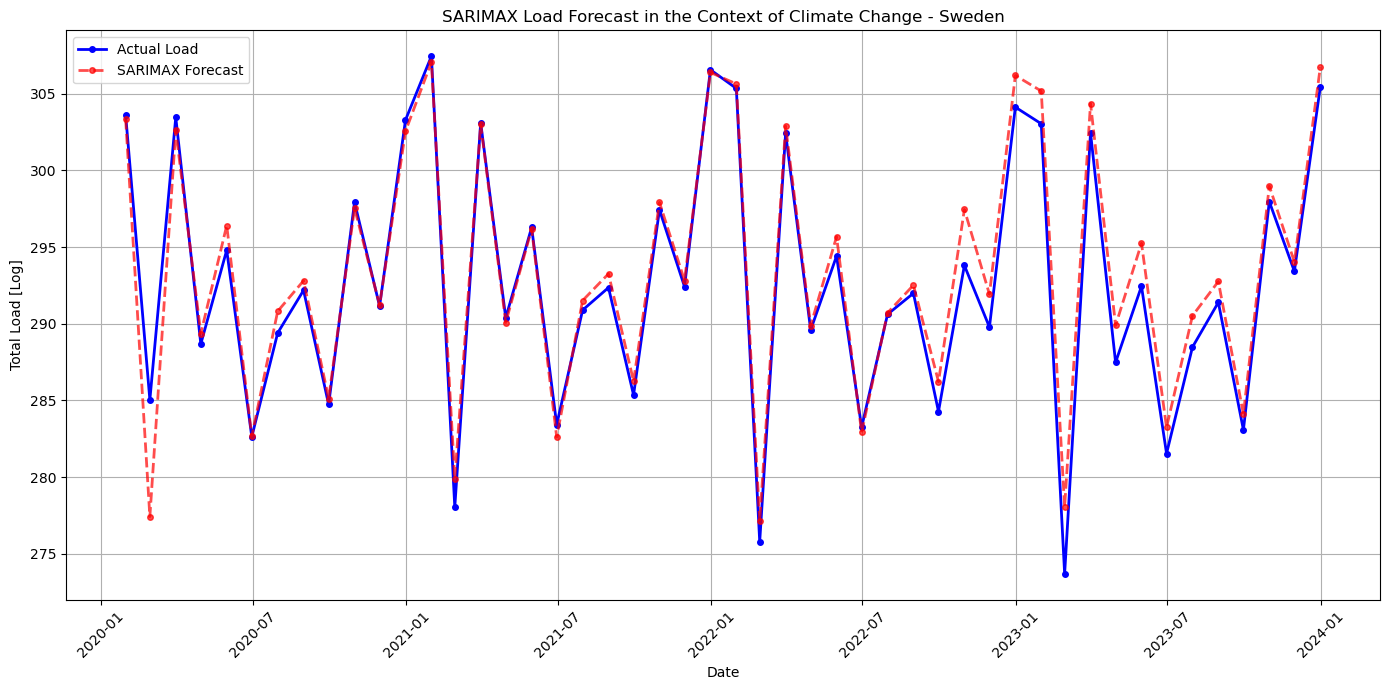

In [37]:
# Plotting the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(predictions2.index, predictions2, label='SARIMAX Forecast', color='red', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('SARIMAX Load Forecast in the Context of Climate Change - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to my winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot5_sarimax2.png'), dpi = 600)  # Save as PNG format

plt.show()

# NOW LET US DEPLOY OUR MACHINE LEARNING MODELS AND CODING FOR RF BASELINE

In [38]:
# Feature Engineering: Creating time-based features from the index
monthly_data['Month'] = monthly_data.index.month
monthly_data['Year'] = monthly_data.index.year

# Selecting the features and target variable
features = ['Temp - Sweden', 'Month', 'Year']
target = 'Log Total Load - Sweden'

# Splitting the dataset into features (X) and target (y) for the machine learning model
X = monthly_data[features]
y = monthly_data[target]

# Splitting the data into training and testing sets for the machine learning model
X_train_ml, X_test_ml = X.loc['2010-01-01':'2019-12-31'], X.loc['2020-01-01':'2023-12-31']
y_train_ml, y_test_ml = y.loc['2010-01-01':'2019-12-31'], y.loc['2020-01-01':'2023-12-31']

# Data Preprocessing: Standardizing the features
scaler = StandardScaler()
X_train_ml_scaled = scaler.fit_transform(X_train_ml)
X_test_ml_scaled = scaler.transform(X_test_ml)

# Model Selection: Choosing Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_regressor.fit(X_train_ml_scaled, y_train_ml)

# Making predictions
predictions_ml = rf_regressor.predict(X_test_ml_scaled)

# Evaluating the model
mse_ml = mean_squared_error(y_test_ml, predictions_ml)
rmse_ml = np.sqrt(mse_ml)
mae_ml = mean_absolute_error(y_test_ml, predictions_ml)
mape_ml = np.mean(np.abs((y_test_ml - predictions_ml) / y_test_ml)) * 100

mse_ml, rmse_ml, mae_ml, mape_ml


(6.301773170533416, 2.510333278776628, 1.78427507540599, 0.6171906733626412)

In [39]:
# Making predictions on the training set
train_predictions_ml = rf_regressor.predict(X_train_ml_scaled)

# Evaluating the model on the training set
mse_in_sample_ml = mean_squared_error(y_train_ml, train_predictions_ml)
rmse_in_sample_ml = np.sqrt(mse_in_sample_ml)
mae_in_sample_ml = mean_absolute_error(y_train_ml, train_predictions_ml)
mape_in_sample_ml = np.mean(np.abs((y_train_ml - train_predictions_ml) / y_train_ml)) * 100

# Printing the in-sample evaluation metrics
print("In-sample Evaluation Metrics for Random Forest Regressor:")
print(f"MSE (In-sample): {mse_in_sample_ml}")
print(f"RMSE (In-sample): {rmse_in_sample_ml}")
print(f"MAE (In-sample): {mae_in_sample_ml}")
print(f"MAPE (In-sample): {mape_in_sample_ml}%")

In-sample Evaluation Metrics for Random Forest Regressor:
MSE (In-sample): 0.8058617336909412
RMSE (In-sample): 0.8976980192085428
MAE (In-sample): 0.515397875648299
MAPE (In-sample): 0.17795751078332042%


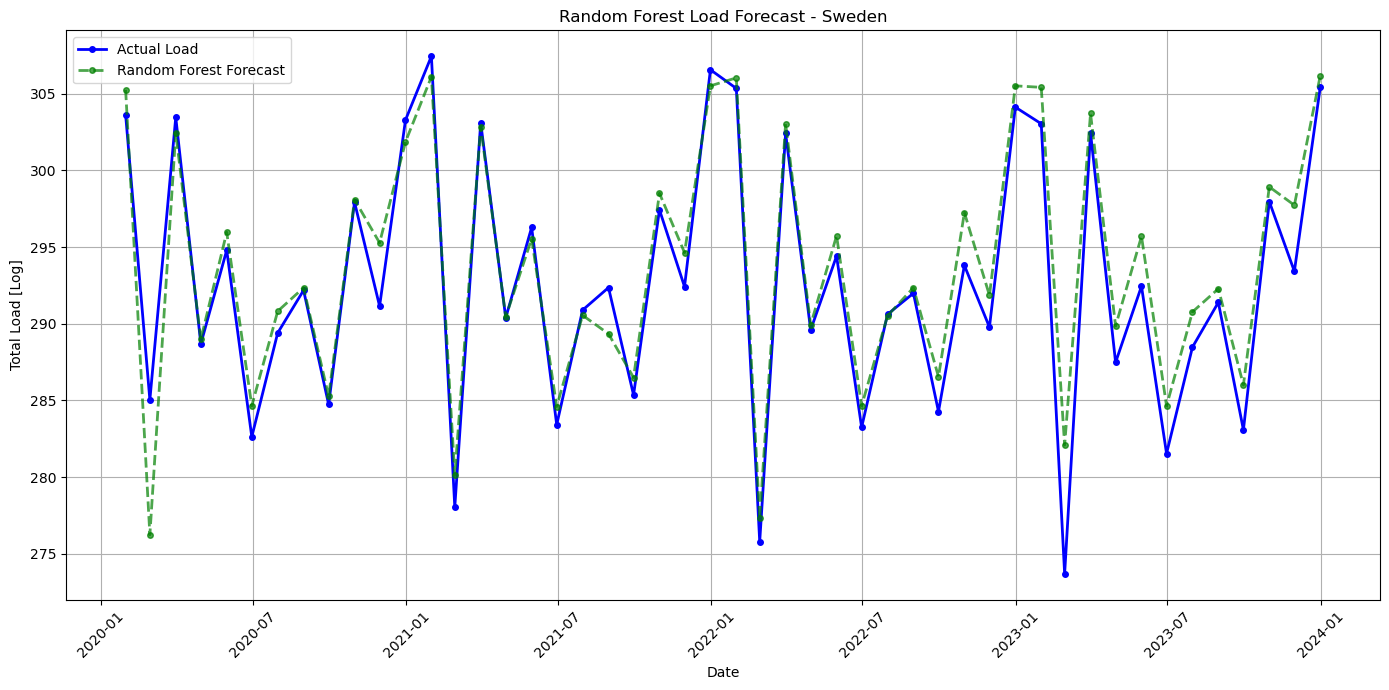

In [40]:
# Plotting the actual vs. predicted values from the Random Forest model
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml.index, y_test_ml, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(y_test_ml.index, predictions_ml, label='Random Forest Forecast', color='green', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('Random Forest Load Forecast - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to the winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot6.png'), dpi = 600)  # Save as PNG format

plt.show()

### GB BASELINE

In [41]:
# Model Selection: Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the model
gb_regressor.fit(X_train_ml_scaled, y_train_ml)

# Making predictions
predictions_gb = gb_regressor.predict(X_test_ml_scaled)

# Evaluating the model
mse_gb = mean_squared_error(y_test_ml, predictions_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test_ml, predictions_gb)
mape_gb = np.mean(np.abs((y_test_ml - predictions_gb) / y_test_ml)) * 100

mse_gb, rmse_gb, mae_gb, mape_gb


(5.551488735445086, 2.3561597431933783, 1.5882358024876868, 0.5474761219408139)

In [42]:
# Making predictions on the training set
train_predictions_gb = gb_regressor.predict(X_train_ml_scaled)

# Evaluating the model on the training set
mse_in_sample_gb = mean_squared_error(y_train_ml, train_predictions_gb)
rmse_in_sample_gb = np.sqrt(mse_in_sample_gb)
mae_in_sample_gb = mean_absolute_error(y_train_ml, train_predictions_gb)
mape_in_sample_gb = np.mean(np.abs((y_train_ml - train_predictions_gb) / y_train_ml)) * 100

# Printing the in-sample evaluation metrics
print("In-sample Evaluation Metrics for Gradient Boosting Regressor:")
print(f"MSE (In-sample): {mse_in_sample_gb}")
print(f"RMSE (In-sample): {rmse_in_sample_gb}")
print(f"MAE (In-sample): {mae_in_sample_gb}")
print(f"MAPE (In-sample): {mape_in_sample_gb}%")

In-sample Evaluation Metrics for Gradient Boosting Regressor:
MSE (In-sample): 0.3305963453709592
RMSE (In-sample): 0.574975082391367
MAE (In-sample): 0.40576826203399796
MAPE (In-sample): 0.13958162968306242%


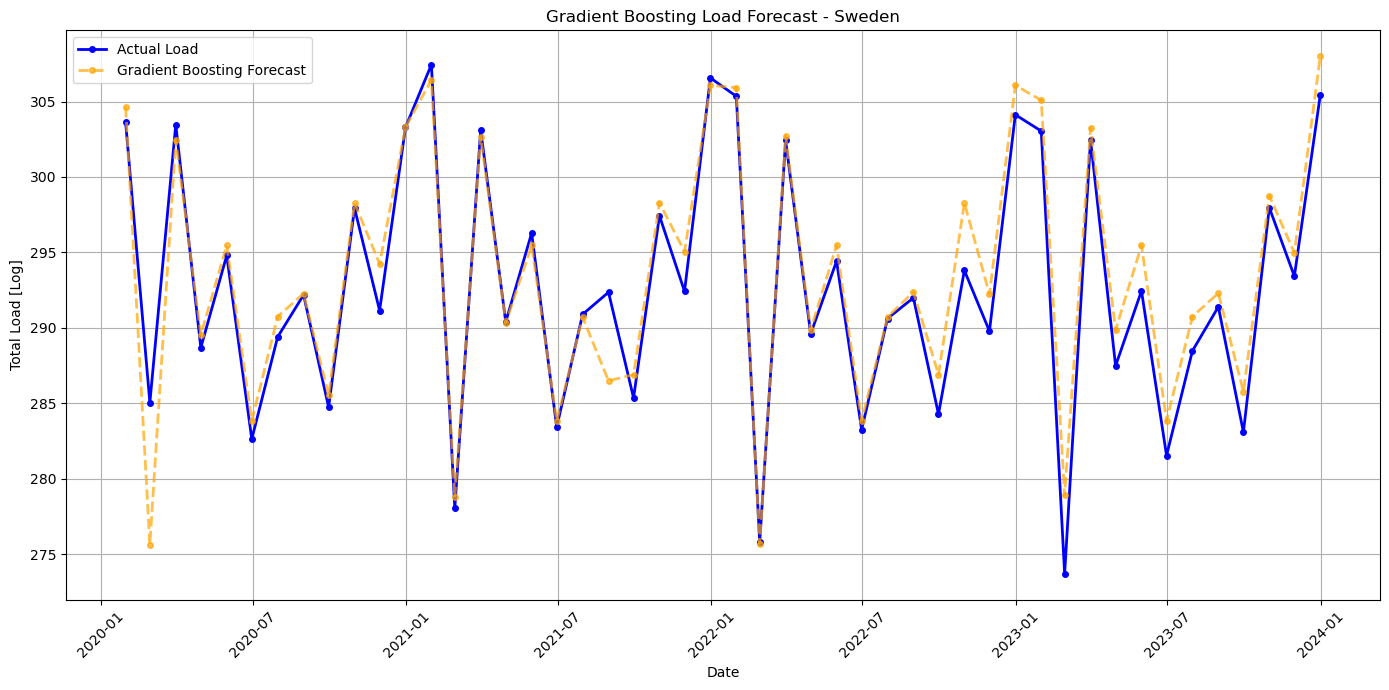

In [43]:
# Plotting the actual vs. predicted values from the Gradient Boosting model
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml.index, y_test_ml, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(y_test_ml.index, predictions_gb, label='Gradient Boosting Forecast', color='orange', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('Gradient Boosting Load Forecast - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to the winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot7.png'), dpi = 600)  # Save as PNG format

plt.show()


# EXTREME WEATHER CONDITIONS AND STARTING WITH RF EXPANDED

In [44]:
# Feature Engineering: Creating time-based features from the index
monthly_data['Month'] = monthly_data.index.month
monthly_data['Year'] = monthly_data.index.year

# Selecting the features and target variable, now including 'Holiday_Sweden'
features_ext = ['Temp - Sweden', 'Month', 'Year', 'Holiday_Sweden', 'Sweden_Temp_Extremes','Climate_Change_Sweden','Clim_ext']  # Added Holiday and extreme temp
target_ext = 'Log Total Load - Sweden'

# Splitting the dataset into features (X) and target (y) for the machine learning model
X = monthly_data[features_ext]
y = monthly_data[target_ext]

# Splitting the data into training and testing sets for machine learning model 
X_train_ml_2, X_test_ml_2 = X.loc['2010-01-01':'2019-12-31'], X.loc['2020-01-01':'2023-12-31']
y_train_ml_2, y_test_ml_2 = y.loc['2010-01-01':'2019-12-31'], y.loc['2020-01-01':'2023-12-31']

# Data Preprocessing: Standardizing the continuous features
scaler_2 = StandardScaler()
# Selecting only continuous features for scaling
continuous_features = ['Temp - Sweden', 'Month', 'Year']
X_train_ml_scaled_2 = X_train_ml_2.copy()
X_test_ml_scaled_2 = X_test_ml_2.copy()

# Applying standardization to continuous features
X_train_ml_scaled_2[continuous_features] = scaler_2.fit_transform(X_train_ml_2[continuous_features])
X_test_ml_scaled_2[continuous_features] = scaler_2.transform(X_test_ml_2[continuous_features])

# Model Selection: Creating a new instance of Random Forest Regressor
rf_regressor_2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the new model
rf_regressor_2.fit(X_train_ml_scaled_2, y_train_ml_2)

# Making predictions with the new model
predictions_ml_2 = rf_regressor_2.predict(X_test_ml_scaled_2)

In [45]:
# Evaluating the new model
mse_ml_2 = mean_squared_error(y_test_ml_2, predictions_ml_2)
rmse_ml_2 = np.sqrt(mse_ml_2)
mae_ml_2 = mean_absolute_error(y_test_ml_2, predictions_ml_2)
mape_ml_2 = np.mean(np.abs((y_test_ml_2 - predictions_ml_2) / y_test_ml_2)) * 100

print("MSE for RF 2:", mse_ml_2)
print("RMSE for RF 2:", rmse_ml_2)
print("MAE for RF 2:", mae_ml_2)
print("MAPE for RF 2:", mape_ml_2)

MSE for RF 2: 4.668088870939735
RMSE for RF 2: 2.1605760507188205
MAE for RF 2: 1.6682254339859857
MAPE for RF 2: 0.5767346037567628


In [46]:
# Making predictions on the training set for the second model
train_predictions_ml_2 = rf_regressor_2.predict(X_train_ml_scaled_2)

# Evaluating the model on the training set
mse_in_sample_ml_2 = mean_squared_error(y_train_ml_2, train_predictions_ml_2)
rmse_in_sample_ml_2 = np.sqrt(mse_in_sample_ml_2)
mae_in_sample_ml_2 = mean_absolute_error(y_train_ml_2, train_predictions_ml_2)
mape_in_sample_ml_2 = np.mean(np.abs((y_train_ml_2 - train_predictions_ml_2) / y_train_ml_2)) * 100

# Printing the in-sample evaluation metrics for my second model - expanded
print("In-sample Evaluation Metrics for Random Forest Regressor 2:")
print(f"MSE (In-sample): {mse_in_sample_ml_2}")
print(f"RMSE (In-sample): {rmse_in_sample_ml_2}")
print(f"MAE (In-sample): {mae_in_sample_ml_2}")
print(f"MAPE (In-sample): {mape_in_sample_ml_2}%")

In-sample Evaluation Metrics for Random Forest Regressor 2:
MSE (In-sample): 0.7161183059951597
RMSE (In-sample): 0.846237736097345
MAE (In-sample): 0.5239626942967415
MAPE (In-sample): 0.18076967208601644%


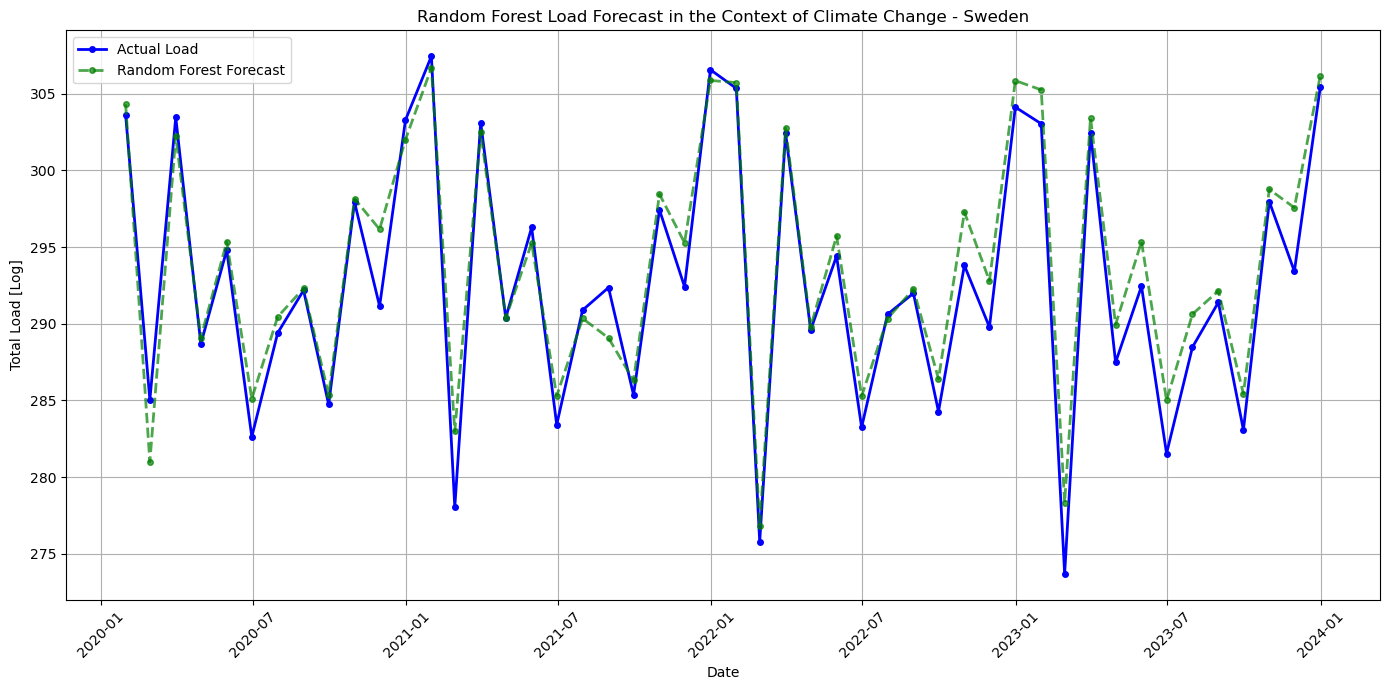

In [47]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(y_test_ml_2.index, predictions_ml_2, label='Random Forest Forecast', color='green', alpha=0.7, marker='.', linestyle='--', linewidth=2,markersize=8)

plt.title('Random Forest Load Forecast in the Context of Climate Change - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Enhancing readability with a grid
plt.tight_layout()
# Save the plot to the specified folder
plt.savefig(os.path.join(my_plots, 'rf_model_2_comparison.png'), dpi=600)  # Save as PNG format at high resolution

plt.show()

# GB EXPANDED

In [48]:
# Model Selection: Gradient Boosting Regressor for the EXPANDED model
gb_regressor_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the second model with the training data including holidays
gb_regressor_2.fit(X_train_ml_scaled_2, y_train_ml_2)

# Making predictions with the second model on the test data
predictions_gb_2 = gb_regressor_2.predict(X_test_ml_scaled_2)

# Evaluating the second model
mse_gb_2 = mean_squared_error(y_test_ml_2, predictions_gb_2)
rmse_gb_2 = np.sqrt(mse_gb_2)
mae_gb_2 = mean_absolute_error(y_test_ml_2, predictions_gb_2)
mape_gb_2 = np.mean(np.abs((y_test_ml_2 - predictions_gb_2) / y_test_ml_2)) * 100

print("MSE for GB Model 2:", mse_gb_2)
print("RMSE for GB Model 2:", rmse_gb_2)
print("MAE for GB Model 2:", mae_gb_2)
print("MAPE for GB Model 2:", mape_gb_2)

MSE for GB Model 2: 3.5421514211861678
RMSE for GB Model 2: 1.8820604191115033
MAE for GB Model 2: 1.422805928039337
MAPE for GB Model 2: 0.48932271571388186


In [49]:
# Making predictions on the training set for the Gradient Boosting model expanded
train_predictions_gb_2 = gb_regressor_2.predict(X_train_ml_scaled_2)

# Evaluating the model on the training set
mse_in_sample_gb_2 = mean_squared_error(y_train_ml_2, train_predictions_gb_2)
rmse_in_sample_gb_2 = np.sqrt(mse_in_sample_gb_2)
mae_in_sample_gb_2 = mean_absolute_error(y_train_ml_2, train_predictions_gb_2)
mape_in_sample_gb_2 = np.mean(np.abs((y_train_ml_2 - train_predictions_gb_2) / y_train_ml_2)) * 100

# Printing the in-sample evaluation metrics for the Gradient Boosting Regressor expanded
print("In-sample Evaluation Metrics for Gradient Boosting Regressor 2:")
print(f"MSE (In-sample): {mse_in_sample_gb_2}")
print(f"RMSE (In-sample): {rmse_in_sample_gb_2}")
print(f"MAE (In-sample): {mae_in_sample_gb_2}")
print(f"MAPE (In-sample): {mape_in_sample_gb_2}%")

In-sample Evaluation Metrics for Gradient Boosting Regressor 2:
MSE (In-sample): 0.16595403991918603
RMSE (In-sample): 0.4073745695538518
MAE (In-sample): 0.31503917538296566
MAPE (In-sample): 0.10800747885606257%


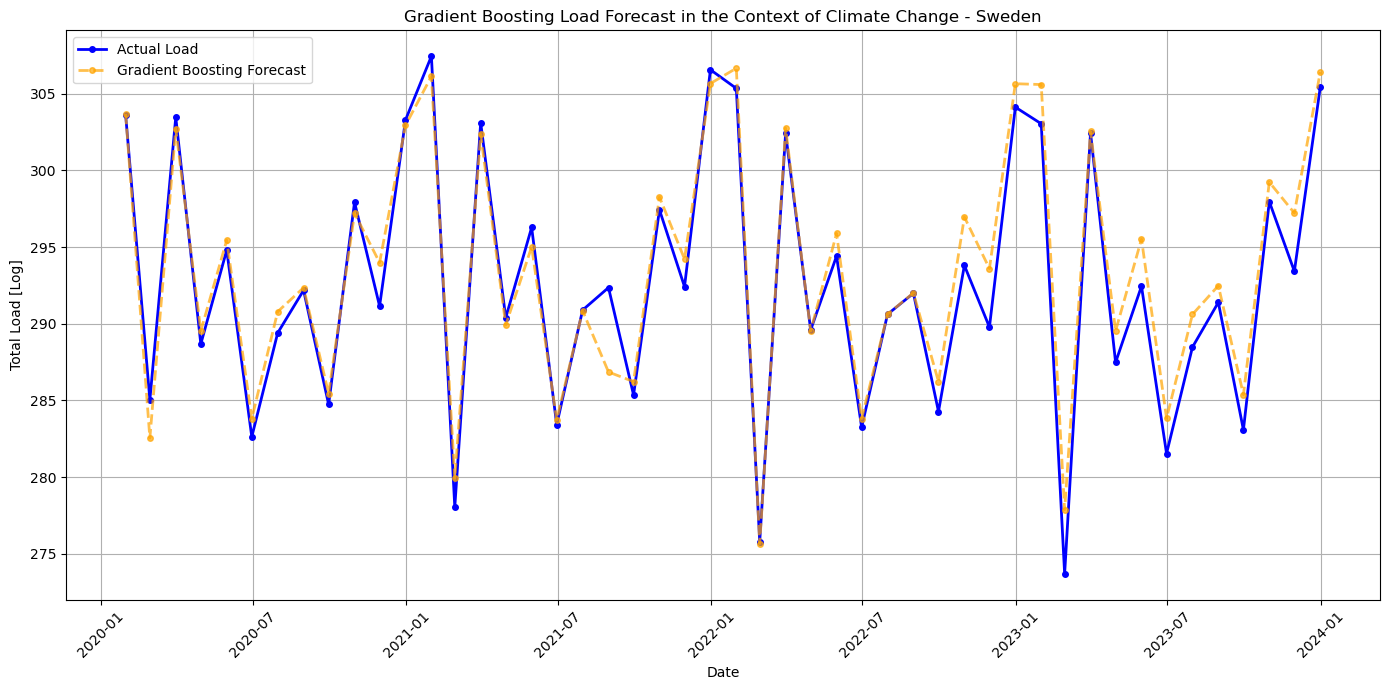

In [50]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2,markersize=8)
plt.plot(y_test_ml_2.index, predictions_gb_2, label='Gradient Boosting Forecast', color='orange', alpha=0.7, marker='.', linestyle='--', linewidth=2,markersize=8)

plt.title('Gradient Boosting Load Forecast in the Context of Climate Change - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  
plt.tight_layout()

plt.savefig(os.path.join(my_plots, 'gb_model_2_comparison.png'), dpi=600)  # Save as PNG format at high resolution

plt.show()

## COMPARING THE FEATURES I CREATED

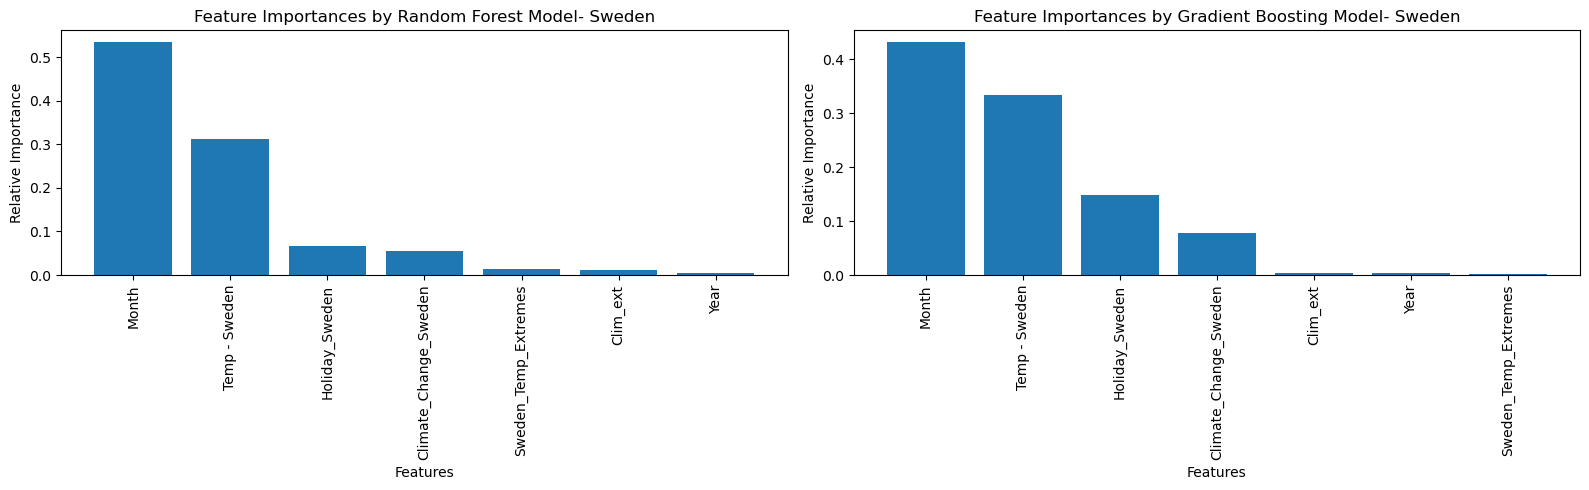

In [51]:
# list of feature names used in my models
features_ext = ['Temp - Sweden', 'Month', 'Year', 'Holiday_Sweden', 'Sweden_Temp_Extremes', 'Climate_Change_Sweden','Clim_ext']

# Get feature importances from both models
importances_rf = rf_regressor_2.feature_importances_
importances_gb = gb_regressor_2.feature_importances_

# Sorting the feature importances in descending order and create indices to arrange them on the x-axis
indices_rf = np.argsort(importances_rf)[::-1]
indices_gb = np.argsort(importances_gb)[::-1]

# Plotting Random Forest feature importances and Gradient Boosting feature importances side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plotting Random Forest feature importances
axes[0].bar(range(len(indices_rf)), importances_rf[indices_rf], align='center')
axes[0].set_title('Feature Importances by Random Forest Model- Sweden')
axes[0].set_xticks(range(len(indices_rf)))
axes[0].set_xticklabels([features_ext[i] for i in indices_rf], rotation=90)
axes[0].set_ylabel('Relative Importance')
axes[0].set_xlabel('Features')

# Plotting Gradient Boosting feature importances
axes[1].bar(range(len(indices_gb)), importances_gb[indices_gb], align='center')
axes[1].set_title('Feature Importances by Gradient Boosting Model- Sweden')
axes[1].set_xticks(range(len(indices_gb)))
axes[1].set_xticklabels([features_ext[i] for i in indices_gb], rotation=90)
axes[1].set_ylabel('Relative Importance')
axes[1].set_xlabel('Features')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'feature.png'), dpi=600)  # Save as PNG format at high resolution to my folder
plt.show()

#### NOW LET’S BUILD THE RESILIENT ELECTRICITY DEMAND FORECASTS IN THE FACE OF CLIMATE CHANGE USING OUR ML MODELS. NEVER MIND ANYMORE

## TIMES SERIES CROSS VALIDATION

In [52]:
# Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=10)

# Lists to store scores for Random Forest
mse_scores_rf = []
mae_scores_rf = []
rmse_scores_rf = []
mape_scores_rf = []
r2_scores_rf = []

# Lists to store scores for Gradient Boosting
mse_scores_gb = []
mae_scores_gb = []
rmse_scores_gb = []
mape_scores_gb = []
r2_scores_gb = []

for train_index, test_index in tscv.split(X_train_ml_scaled_2):
    # Split data
    X_train_fold, X_test_fold = X_train_ml_scaled_2.iloc[train_index], X_train_ml_scaled_2.iloc[test_index]
    y_train_fold, y_test_fold = y_train_ml_2.iloc[train_index], y_train_ml_2.iloc[test_index]

    # Instantiate models
    rf_regressor_fold = RandomForestRegressor(n_estimators=100, random_state=42)
    gb_regressor_fold = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    # Fit models
    rf_regressor_fold.fit(X_train_fold, y_train_fold)
    gb_regressor_fold.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    rf_predictions_fold = rf_regressor_fold.predict(X_test_fold)
    gb_predictions_fold = gb_regressor_fold.predict(X_test_fold)

    # Calculate and collect all metrics for each fold for Random Forest
    mse_scores_rf.append(mean_squared_error(y_test_fold, rf_predictions_fold))
    mae_scores_rf.append(mean_absolute_error(y_test_fold, rf_predictions_fold))
    rmse_scores_rf.append(np.sqrt(mean_squared_error(y_test_fold, rf_predictions_fold)))
    mape_scores_rf.append(np.mean(np.abs((y_test_fold - rf_predictions_fold) / y_test_fold)) * 100)
    r2_scores_rf.append(r2_score(y_test_fold, rf_predictions_fold))

    # Calculate and collect all metrics for each fold for Gradient Boosting
    mse_scores_gb.append(mean_squared_error(y_test_fold, gb_predictions_fold))
    mae_scores_gb.append(mean_absolute_error(y_test_fold, gb_predictions_fold))
    rmse_scores_gb.append(np.sqrt(mean_squared_error(y_test_fold, gb_predictions_fold)))
    mape_scores_gb.append(np.mean(np.abs((y_test_fold - gb_predictions_fold) / y_test_fold)) * 100)
    r2_scores_gb.append(r2_score(y_test_fold, gb_predictions_fold))

# Calculate the average of all metrics across all folds for each model
avg_mse_rf = np.mean(mse_scores_rf)
avg_mae_rf = np.mean(mae_scores_rf)
avg_rmse_rf = np.mean(rmse_scores_rf)
avg_mape_rf = np.mean(mape_scores_rf)
avg_r2_rf = np.mean(r2_scores_rf)

avg_mse_gb = np.mean(mse_scores_gb)
avg_mae_gb = np.mean(mae_scores_gb)
avg_rmse_gb = np.mean(rmse_scores_gb)
avg_mape_gb = np.mean(mape_scores_gb)
avg_r2_gb = np.mean(r2_scores_gb)

# Printing out the average metrics for both models
print(f"Random Forest - MSE: {avg_mse_rf}, MAE: {avg_mae_rf}, RMSE: {avg_rmse_rf}, MAPE: {avg_mape_rf}, R2: {avg_r2_rf}")
print(f"Gradient Boosting - MSE: {avg_mse_gb}, MAE: {avg_mae_gb}, RMSE: {avg_rmse_gb}, MAPE: {avg_mape_gb}, R2: {avg_r2_gb}")

Random Forest - MSE: 13.851382057415611, MAE: 2.4561093839391375, RMSE: 3.3229166275008692, MAPE: 0.8394699886968129, R2: 0.7961953961795658
Gradient Boosting - MSE: 8.989776166297379, MAE: 1.8025241878693676, RMSE: 2.6124376181986015, MAPE: 0.6193584481405686, R2: 0.8667140508456894


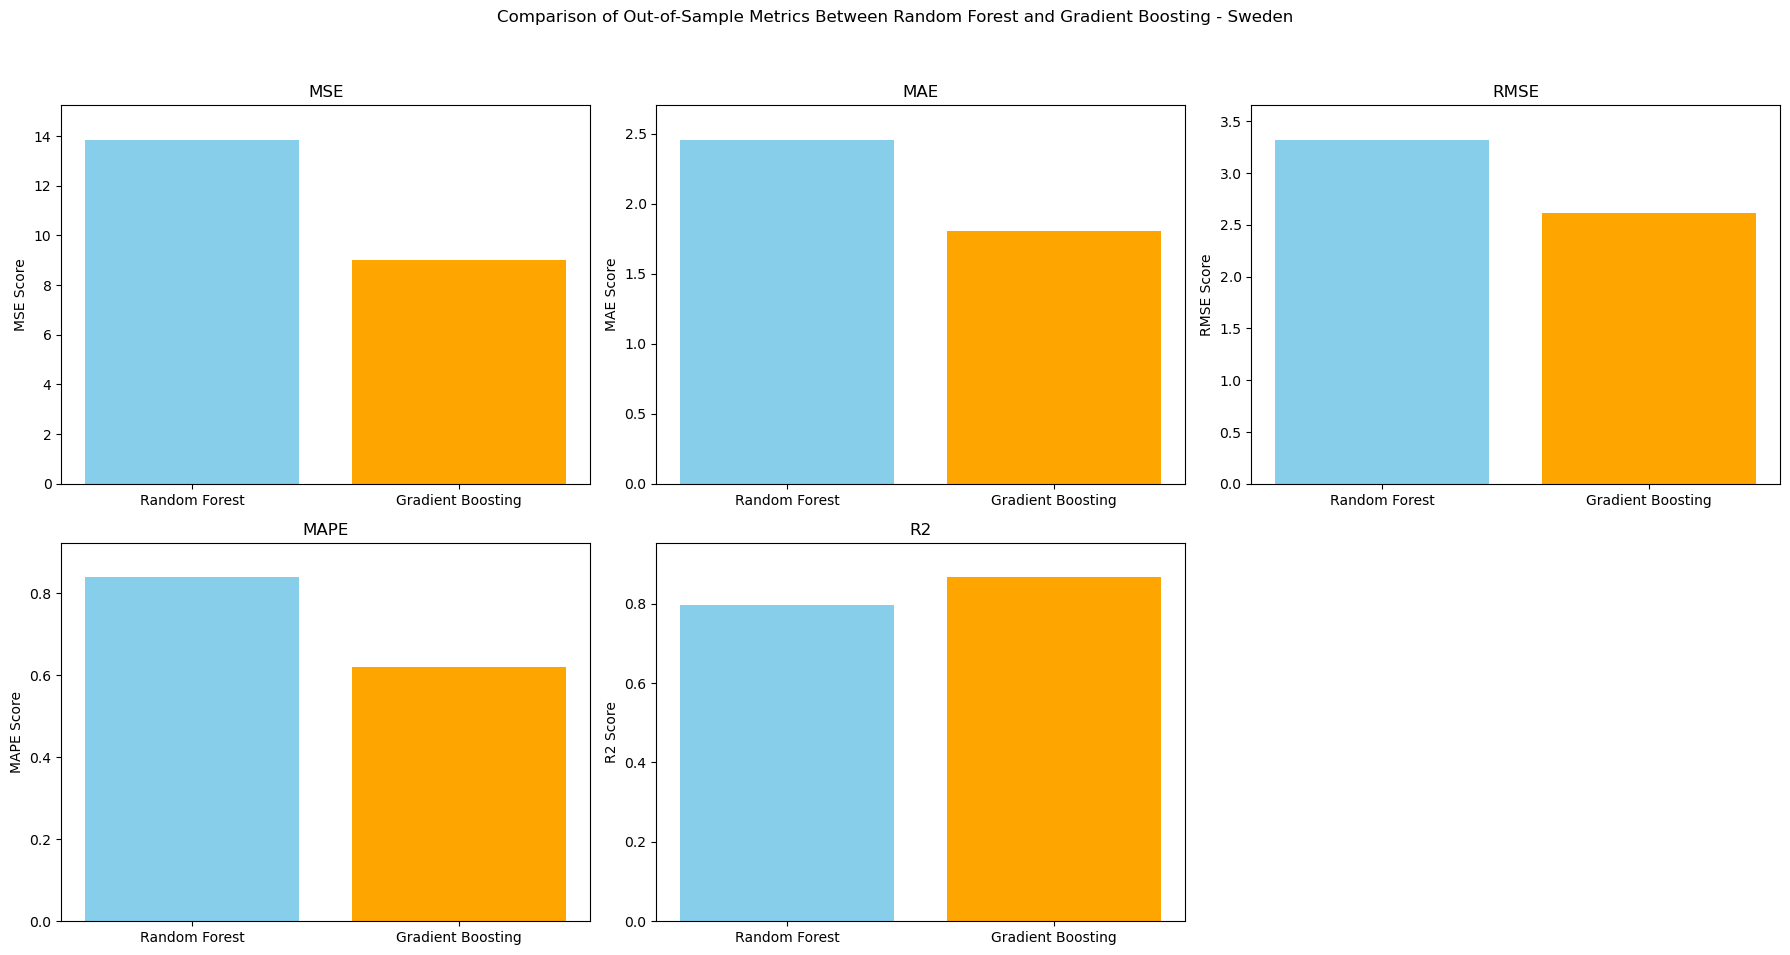

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison of Out-of-Sample Metrics Between Random Forest and Gradient Boosting - Sweden')

# List of metrics for plotting
metrics_values = [(avg_mse_rf, avg_mse_gb, 'MSE'), 
                  (avg_mae_rf, avg_mae_gb, 'MAE'), 
                  (avg_rmse_rf, avg_rmse_gb, 'RMSE'), 
                  (avg_mape_rf, avg_mape_gb, 'MAPE'), 
                  (avg_r2_rf, avg_r2_gb, 'R2')]

# Plotting each metric in a separate subplot
for ax, (rf_val, gb_val, metric_name) in zip(axes.flatten(), metrics_values):
    ax.bar('Random Forest', rf_val, color='skyblue')
    ax.bar('Gradient Boosting', gb_val, color='orange')
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name + ' Score')
    ax.set_ylim(0, max(rf_val, gb_val) * 1.1)  # Setting y limit for better comparison

# Hiding the 6th subplot (as we have only 5 metrics)
axes[1, 2].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(my_plots, 'plot11.png'), dpi = 600)  # Save as PNG format
plt.show()

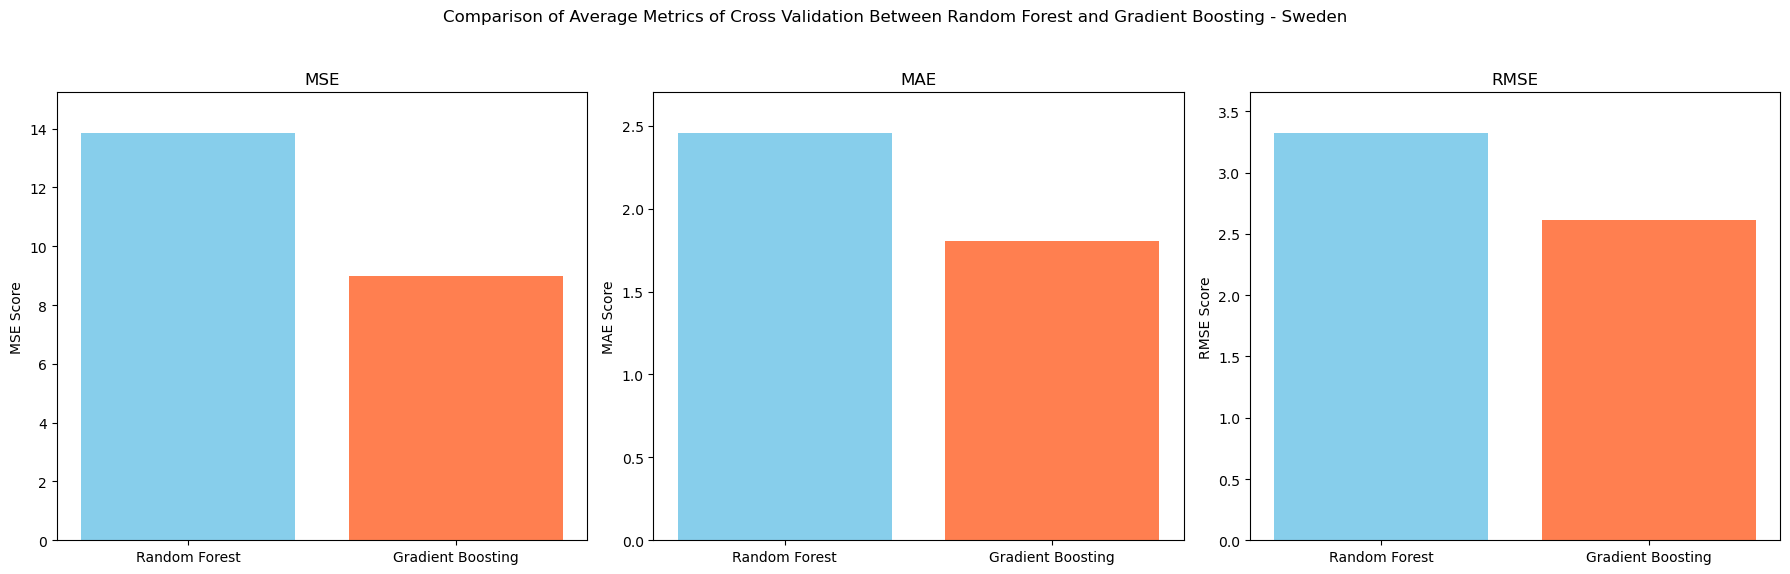

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted for a 1x3 grid
fig.suptitle('Comparison of Average Metrics of Cross Validation Between Random Forest and Gradient Boosting - Sweden')

# my values defined here
#avg_mse_rf, avg_mse_gb = 1217717.567079088, 1044886.5317915119
#avg_mae_rf, avg_mae_gb = 892.0145622816465, 831.2262394162437
#avg_rmse_rf, avg_rmse_gb = 1102.0497905156303, 1019.703103435139

# List of metrics for plotting, updated to include only MSE, MAE, RMSE
metrics_values = [
    (avg_mse_rf, avg_mse_gb, 'MSE'), 
    (avg_mae_rf, avg_mae_gb, 'MAE'), 
    (avg_rmse_rf, avg_rmse_gb, 'RMSE')
]

# Plotting each metric in a separate subplot
for ax, (rf_val, gb_val, metric_name) in zip(axes, metrics_values):
    ax.bar('Random Forest', rf_val, color='skyblue')
    ax.bar('Gradient Boosting', gb_val, color='coral')
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name + ' Score')
    ax.set_ylim(0, max(rf_val, gb_val) * 1.1)  # Setting y limit for better comparison

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(my_plots, 'outsamp.png'), dpi=600)  # Save as PNG format
plt.show()


In [55]:
# Lists to store in-sample scores for Random Forest
mse_train_rf = []
mae_train_rf = []
rmse_train_rf = []
mape_train_rf = []
r2_train_rf = []

# Lists to store in-sample scores for Gradient Boosting
mse_train_gb = []
mae_train_gb = []
rmse_train_gb = []
mape_train_gb = []
r2_train_gb = []

# Out-of-sample metrics (your existing code)
for train_index, test_index in tscv.split(X_train_ml_scaled):
    # Split data
    X_train_fold, X_test_fold = X_train_ml_scaled[train_index], X_train_ml_scaled[test_index]
    y_train_fold, y_test_fold = y_train_ml.iloc[train_index], y_train_ml.iloc[test_index]

    # Instantiate models
    rf_regressor_fold = RandomForestRegressor(n_estimators=100, random_state=42)
    gb_regressor_fold = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    # Fit models
    rf_regressor_fold.fit(X_train_fold, y_train_fold)
    gb_regressor_fold.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    rf_predictions_fold = rf_regressor_fold.predict(X_test_fold)
    gb_predictions_fold = gb_regressor_fold.predict(X_test_fold)

    # Predict on the training fold (in-sample predictions)
    rf_train_predictions = rf_regressor_fold.predict(X_train_fold)
    gb_train_predictions = gb_regressor_fold.predict(X_train_fold)

    # Calculate and collect all in-sample metrics for Random Forest
    mse_train_rf.append(mean_squared_error(y_train_fold, rf_train_predictions))
    mae_train_rf.append(mean_absolute_error(y_train_fold, rf_train_predictions))
    rmse_train_rf.append(np.sqrt(mean_squared_error(y_train_fold, rf_train_predictions)))
    mape_train_rf.append(np.mean(np.abs((y_train_fold - rf_train_predictions) / y_train_fold)) * 100)
    r2_train_rf.append(r2_score(y_train_fold, rf_train_predictions))

    # Calculate and collect all in-sample metrics for Gradient Boosting
    mse_train_gb.append(mean_squared_error(y_train_fold, gb_train_predictions))
    mae_train_gb.append(mean_absolute_error(y_train_fold, gb_train_predictions))
    rmse_train_gb.append(np.sqrt(mean_squared_error(y_train_fold, gb_train_predictions)))
    mape_train_gb.append(np.mean(np.abs((y_train_fold - gb_train_predictions) / y_train_fold)) * 100)
    r2_train_gb.append(r2_score(y_train_fold, gb_train_predictions))

# Calculating the average in-sample metrics for both models across all folds
avg_mse_train_rf = np.mean(mse_train_rf)
avg_mae_train_rf = np.mean(mae_train_rf)
avg_rmse_train_rf = np.mean(rmse_train_rf)
avg_mape_train_rf = np.mean(mape_train_rf)
avg_r2_train_rf = np.mean(r2_train_rf)

avg_mse_train_gb = np.mean(mse_train_gb)
avg_mae_train_gb = np.mean(mae_train_gb)
avg_rmse_train_gb = np.mean(rmse_train_gb)
avg_mape_train_gb = np.mean(mape_train_gb)
avg_r2_train_gb = np.mean(r2_train_gb)

# Printing out the average in-sample metrics for both models
print(f"Random Forest In-Sample - MSE: {avg_mse_train_rf}, MAE: {avg_mae_train_rf}, RMSE: {avg_rmse_train_rf}, MAPE: {avg_mape_train_rf}, R2: {avg_r2_train_rf}")
print(f"Gradient Boosting In-Sample - MSE: {avg_mse_train_gb}, MAE: {avg_mae_train_gb}, RMSE: {avg_rmse_train_gb}, MAPE: {avg_mape_train_gb}, R2: {avg_r2_train_gb}")

Random Forest In-Sample - MSE: 4.263284810616739, MAE: 1.2876210978441036, RMSE: 1.82036903124765, MAPE: 0.43855843648440274, R2: 0.9460456095957503
Gradient Boosting In-Sample - MSE: 0.19525771140178896, MAE: 0.31788937002503626, RMSE: 0.41097153798829933, MAPE: 0.10891224170847161, R2: 0.9973588118377353


The Gradient Boosting model generally outperforms the Random Forest model across all metrics. The Gradient Boosting model has lower MSE, MAE, RMSE, MAPE, and higher R2 compared to the Random Forest model. A simplified AIC/BIC also leans towards the GB ML model. This indicates that the Gradient Boosting model provides better predictions and captures more variance in the data. Based on these evaluation metrics, the Gradient Boosting appears to be the **MOST RESILIENT MACHINE LEARNING MODEL**.

# ENHANCING THE MODELS TO BETTER THE PERFORMANCE OF THE FORECASTS

In [56]:
# Assigning weights inversely proportional to MSE
weight_sarimax = 1 / mse_sarimax2
weight_ml_2 = 1 / mse_ml_2

# Normalizing weights
total_weight = weight_sarimax + weight_ml_2
weight_sarimax /= total_weight
weight_ml_2 /= total_weight

# Combining the forecasts using weighted average
ensemble_forecasts = (sarimax_forecasts * weight_sarimax + predictions_ml_2 * weight_ml_2)

# Evaluatiin metrics for the ensemble forecasts
mse_ensemble = mean_squared_error(y_test_ml_2, ensemble_forecasts)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(y_test_ml_2, ensemble_forecasts)
mape_ensemble = np.mean(np.abs((y_test_ml_2 - ensemble_forecasts) / y_test_ml_2)) * 100

print(f"Ensemble Forecast MSE: {mse_ensemble}")
print(f"Ensemble Forecast RMSE: {rmse_ensemble}")
print(f"Ensemble Forecast MAE: {mae_ensemble}")
print(f"Ensemble Forecast MAPE: {mape_ensemble}%")

NameError: name 'sarimax_forecasts' is not defined

In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual load data
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=1, markersize=8)

# Plot individual model forecasts
plt.plot(y_test_ml_2.index, sarimax_forecasts, label='SARIMAX', color='red', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)
plt.plot(y_test_ml_2.index, predictions_ml_2, label='Random Forest', color='green', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)

# Plot ensemble forecasts
plt.plot(y_test_ml_2.index, ensemble_forecasts, label='Enhanced Forecast', color='darkorchid', alpha=0.7, marker='.', linestyle='--', linewidth=1, markersize=8)

# Customizing the plot
plt.title('SARIMAX and Random Forest Enhanced Load Forecast - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'comp1.png'), dpi = 600)  # Save as PNG format

### SARIMAX & GB

In [ ]:
# Calculating inverse weights based on MSE
weight_sarimax = 1 / mse_sarimax2
weight_gb = 1 / mse_gb_2

# Normalizing the weights so that they sum to 1
total_weight2 = weight_sarimax + weight_gb
weight_sarimax /= total_weight2
weight_gb /= total_weight2

# Combining predictions using weighted average
combined_predictions = (sarimax_forecasts * weight_sarimax + predictions_gb_2 * weight_gb)

In [ ]:
# Evaluating the ensemble model's performance
mse_combined = mean_squared_error(y_test_ml_2, combined_predictions)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(y_test_ml_2, combined_predictions)
mape_combined = np.mean(np.abs((y_test_ml_2 - combined_predictions) / y_test_ml_2)) * 100

# Printing results
print(f"Combined Model MSE: {mse_combined}")
print(f"Combined Model RMSE: {rmse_combined}")
print(f"Combined Model MAE: {mae_combined}")
print(f"Combined Model MAPE: {mape_combined}%")

In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual load data
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=1, markersize=8)

# Plotting individual model forecasts
plt.plot(y_test_ml_2.index, sarimax_forecasts, label='SARIMAX', color='red', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)
plt.plot(y_test_ml_2.index, predictions_gb_2, label='Gradient Boosting', color='orange', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)

# Plotting ensemble forecasts
plt.plot(y_test_ml_2.index, combined_predictions, label='Enhanced Forecast', color='darkorchid', alpha=0.7, marker='.', linestyle='--', linewidth=1, markersize=8)

# Customizing the plot
plt.title('SARIMAX and Gradient Boosting Enhanced Load Forecast - Sweden')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'comp2.png'), dpi = 600)  # Save as PNG format

# Display it here
plt.show()